# Sentiment Analysis of \#TTC Tweets - Part 1 of 3

The Toronto Transit Commission, more commonly referred to as the TTC, provides public transit to millions of Torontonians. However, many Torontonians do not hold the TTC in very high regard, with some jokingly suggesting that TTC stands for "take the car".

In this project we conduct sentiment analysis on tweets with the #TTC hashtag. We shall limit our tweets to those originating near Toronto and between the dates of January 1, 2014 and June 30, 2021, inclusive. We hope to discover interesting trends in these tweets. In particular, we shall explore the possibility of whether sentiment correlates with factors such as service delays or subway closures.

The Tweets will be scraped via the development version of [snscrape](https://github.com/JustAnotherArchivist/snscrape). Information regarding subway closures is extracted from the [TTC News page](http://www.ttc.ca/News/index.jsp). As for transit delay data, this is obtained from the City of Toronto's [Open Data Portal](https://open.toronto.ca/). The Open Data Portal publishes a wealth of information and we shall use the available data pertaining to [bus](https://open.toronto.ca/dataset/ttc-bus-delay-data/), [streetcar](https://open.toronto.ca/dataset/ttc-streetcar-delay-data/), and [subway](https://open.toronto.ca/dataset/ttc-subway-delay-data/) delays.

This notebook will cover Part 1 of this project in which we clean the Twitter data, conduct sentiment analysis, and look for trends in the Twitter data. In Part 2 we shall incorporate subway closure data and look for correlations with the Twitter data. In Part 3 we will examine the transit delay data as well and try to link it to our Twitter dataset.

## Importing Libraries

We start by importing the necessary libraries. 

In [1]:
# import libraries
import numpy as np # for arrays
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for data visualization
import datetime # for handling dates
from datetime import datetime as dt # also for dates
import calendar # also for dates
import string # for strings
import re # for regular expressions
from nltk.sentiment.vader import SentimentIntensityAnalyzer # for sentiment analysis
from nltk import tokenize # for tokenizing text
from scipy import stats # for statistics test
from statsmodels.stats.multitest import multipletests # for applying Holm-Bonferroni corrections
from wordcloud import WordCloud # for word clouds
import folium # for mapping
from folium.plugins import HeatMap # for heatmaps

# set preferences
sns.set_style('whitegrid')
%matplotlib inline
pd.set_option('display.max_colwidth', 400)

## Scraping Tweets

We begin by scraping tweets with the #TTC hashtag. We shall only scrape tweets with between January 1, 2014 and June 30, 2021, inclusive, because the Open Data Portal has published delay data for precisely this period. Moreover, we apply a geographic filter since globally the #TTC hashtag can represent a plethora of topics. If we simply take all tweets with the #TTC hashtag, we will get tweets referring to

* "trying to conceive"
* "time to celebrate"
* TTCrypto, a TikTok-related cryptocurrency
* the Tennessee Titans cheerleaders
* takethiscourse.net
* The Taste Company
* Trade and Technology Council
* Telford Triathlon Club
* the PBS show "To the Contrary"
* The Tinted Club
* Teachers' Training Course
* Top Training Club
* The Teepee Culture
* The Trainers Consortium

among many others. As such it is crucial that we filter by location if we want to maximize the possibility that the tweets are indeed referring to the Toronto Transit Commission.

Filtering by location introduces its own downsides however. Most tweets do not have precise location data and so our geographic filter is going to exclude many pertinent tweets. While it would be ideal to get all relevant tweets with the #TTC hashtag, it turns out that this should not be a problem if we make the fairly reasonable assumption that the Twitter users which have specified their location are a representative sample of general Twitter users.

Let's go ahead and start scraping now. The code below will download and save the tweets as csv files, one for each year, and then combine them into a single dataframe.

In [2]:
# set hashtag
hashtag = '#TTC'

# set language
lang = 'en'

# set location and search radius
loc = '43.6532, -79.3832, 50km'

# list of years
years = range(2014, 2022)

# loop through years
for year in years:
    
    # print status
    print('Currently scraping tweets from {}'.format(year))
    
    # start date
    start = '{}-01-01'.format(year)
    
    # end date
    if year == 2021:
        end = '2021-07-01'
    else:
        end = '{}-01-01'.format(year + 1)
    
    # current search criteria
    search = '{} lang:{} geocode:"{}" since:{} until:{}'.format(hashtag, lang, loc, start, end)
    
    # UNCOMMENT THE BELOW BLOCK OF CODE TO ACTUALLY SCRAPE
    
    """
    # create dataframe of each year's tweets
    tweets = sntwitter.TwitterSearchScraper(search).get_items()
    curr_df = pd.DataFrame(tweets)
    
    # save current dataframe
    filename = 'tweets/tweets_{}.csv'.format(year)
    curr_df.to_csv(path_or_buf = filename)
    """

# loop through years
first = True
for year in years[::-1]:
    file = 'tweets/tweets_{}.csv'.format(year)
    
    # initialize the dataframe
    if first:
        tweets = pd.read_csv(file, index_col = 0)
        first = False
        
    # append later dataframes
    else:
        temp_df = pd.read_csv(file, index_col = 0)
        tweets = pd.concat([tweets, temp_df])
        
# reset index
tweets.reset_index(drop = True, inplace = True)

Currently scraping tweets from 2014
Currently scraping tweets from 2015
Currently scraping tweets from 2016
Currently scraping tweets from 2017
Currently scraping tweets from 2018
Currently scraping tweets from 2019
Currently scraping tweets from 2020
Currently scraping tweets from 2021


## Cleaning the Twitter Data

The Twitter data is the dataset that we are largely interested. Let's start by taking a look at what we have.

In [3]:
# preview Twitter data
tweets.head()

,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,media,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags
0,https://twitter.com/pattisonoutdoor/status/1409944271206203398,2021-06-29 18:38:04+00:00,#NowLive @BudLightCA brings a splash of COLOUR to the streets of Toronto in celebration of #PrideMonth with this BOLD Flexity Streetcar Wrap travelling through the city. #TTC #TransitAdvertising https://t.co/dgOFYJBfUr,#NowLive @BudLightCA brings a splash of COLOUR to the streets of Toronto in celebration of #PrideMonth with this BOLD Flexity Streetcar Wrap travelling through the city. #TTC #TransitAdvertising https://t.co/dgOFYJBfUr,1409944271206203398,"{'username': 'pattisonoutdoor', 'id': 49756364, 'displayname': 'PATTISON Outdoor', 'description': ""Canada's largest Outdoor, Digital & Transit Advertising company. We help brands and businesses harness the power of Out-of-Home advertising."", 'rawDescription': ""Canada's largest Outdoor, Digital & Transit Advertising company. We help brands and businesses harness the power of Out-of-Home adverti...",0,0,1,0,...,"[{'previewUrl': 'https://pbs.twimg.com/media/E5Eg1eAWUAEYHmX?format=jpg&name=small', 'fullUrl': 'https://pbs.twimg.com/media/E5Eg1eAWUAEYHmX?format=jpg&name=large'}]",NaN,NaN,NaN,NaN,"[{'username': 'BudLightCA', 'id': 2228573966, 'displayname': 'Bud Light', 'description': None, 'rawDescription': None, 'descriptionUrls': None, 'verified': None, 'created': None, 'followersCount': None, 'friendsCount': None, 'statusesCount': None, 'favouritesCount': None, 'listedCount': None, 'mediaCount': None, 'location': None, 'protected': None, 'linkUrl': None, 'linkTcourl': None, 'profile...","{'longitude': -79.810142, 'latitude': 43.373074}","{'fullName': 'Mississauga, Ontario', 'name': 'Mississauga', 'type': 'city', 'country': 'Canada', 'countryCode': 'CA'}","['NowLive', 'PrideMonth', 'TTC', 'TransitAdvertising']",NaN
1,https://twitter.com/VivaItalia15/status/1409700610723651587,2021-06-29 02:29:51+00:00,My car was in the shop today so I rode @MiWayHelps for 1st time in long time\n\nWas shocked to pay $4 one-way💰that’s more expensive than #TTC for less services,My car was in the shop today so I rode @MiWayHelps for 1st time in long time\n\nWas shocked to pay $4 one-way💰that’s more expensive than #TTC for less services,1409700610723651587,"{'username': 'VivaItalia15', 'id': 1137514169702453248, 'displayname': 'Angelo DG 🇨🇦🇮🇹 🏳️\u200d🌈', 'description': 'Sales consultant gently used cars | My passion to exceed client expectations only surpasses by my passion for #equity #pride #SocialJustice in our community', 'rawDescription': 'Sales consultant gently used cars | My passion to exceed client expectations only surpasses by my passi...",0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,"[{'username': 'MiWayHelps', 'id': 573908194, 'displayname': 'Customer Service', 'description': None, 'rawDescription': None, 'descriptionUrls': None, 'verified': None, 'created': None, 'followersCount': None, 'friendsCount': None, 'statusesCount': None, 'favouritesCount': None, 'listedCount': None, 'mediaCount': None, 'location': None, 'protected': None, 'linkUrl': None, 'linkTcourl': None, 'p...","{'longitude': -79.6408435483377, 'latitude': 43.558506352599274}","{'fullName': 'Cedarglen Gate', 'name': 'Cedarglen Gate', 'type': 'poi', 'country': 'Canada', 'countryCode': 'CA'}",['TTC'],NaN
2,https://twitter.com/randyfmcdonald/status/1409645830202560513,2021-06-28 22:52:10+00:00,Seen in the neo-liberal hipster mecca (1) #toronto #trinitybellwoodspark #dundasstreetwest #statue #simonbolivar #505dundas #ttc #streetcar #green @ Trinity Bellwoods Park https://t.co/LiKogSm8cY,Seen in the neo-liberal hipster mecca (1) #toronto #trinitybellwoodspark #dundasstreetwest #statue #simonbolivar #505dundas #ttc #streetcar #green @ Trinity Bellwoods Park instagram.com/p/CQrmkLkNITK/…,1409645830202560513,"{'username': 'randyfmcdonald', 'id': 18154

In [4]:
# Twitter dataset features
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22700 entries, 0 to 22699
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   url               22700 non-null  object 
 1   date              22700 non-null  object 
 2   content           22700 non-null  object 
 3   renderedContent   22700 non-null  object 
 4   id                22700 non-null  int64  
 5   user              22700 non-null  object 
 6   replyCount        22700 non-null  int64  
 7   retweetCount      22700 non-null  int64  
 8   likeCount         22700 non-null  int64  
 9   quoteCount        22700 non-null  int64  
 10  conversationId    22700 non-null  int64  
 11  lang              22700 non-null  object 
 12  source            22700 non-null  object 
 13  sourceUrl         22700 non-null  object 
 14  sourceLabel       22700 non-null  object 
 15  outlinks          6625 non-null   object 
 16  tcooutlinks       6625 non-null   object

The Twitter data consists of 22700 tweets with 8 numerical features and 19 non-numerical features. We have

* **url** - url of the tweet. Safe to drop
* **date** - date and time of the tweet
* **content** - content of the tweet but links are replaced with a shortened t.co link
* **renderedContent** - original content of the tweet, i.e. the same as **content** except any links are in their original format. Due to similarity with **content**, we can safely drop this feature
* **id** - id of the tweet. Safe to drop
* **user** - dictionary storing user information such as their username, Twitter id, display name, description, and much more
* **replyCount** - the number of replies the tweet got
* **retweetCount** - the number of times the tweet was retweeted
* **likeCount** - the number of likes the tweet got
* **quoteCount** - the number of users that quoted the tweet
* **conversationId** - id of the conversation the tweet is part of. Safe to drop
* **lang** - language of the tweet. All tweets are in English and hence this feature is safe to drop
* **source** - where the tweet was posted from, e.g. from an iPhone, iPad, and Android device, etc. Contains both the url and label data
* **sourceUrl** - url corresponding to the **source** value
* **sourceLabel** - label corresponding to the **source** value. Due to redundancy with the previous two features, we can drop **source** and **sourceUrl**
* **outlinks** - list of links appearing in the tweet
* **tcooutlinks** - Twitter shortened version of the links in **outlinks**. Due to redundancy with **outlinks** we drop **outlinks**
* **media** - links to any media in the tweet
* **retweetedTweet** - if the tweet is a retweet, the id of the original tweet is given here. Since this feature is empty in our dataset, we drop it
* **quotedTweet** - if the tweet quoted another, the id of the original tweet is given here. This won't be too useful so we drop this feaure.
* **inReplyToTweetId** - if the tweet is a reply, the id of the original tweet is given here. Not too useful so we drop this feature.
* **inReplyToUser** - if the tweet is a reply, the user info of the original tweet is given here. We drop this feature.
* **mentionedUsers** - a list of users mentioned in the tweet
* **coordinates** - geographical coordinates of the user when the tweet was created
* **place** - location of the user when the tweet was created. Due to our geographic filter this feature can be dropped
* **hashtags** - list of hashtags in tweet
* **cashtags** - list of cashtags in tweet

Let's start by dropping the unnecessary features in the dataset.

In [5]:
# drop unneeded features
tweets.drop(['url', 'renderedContent', 'id', 'conversationId', 'lang', 'source', 'sourceUrl', 'outlinks',
             'retweetedTweet', 'quotedTweet', 'inReplyToTweetId', 'inReplyToUser', 'place'], axis = 1, inplace = True)

Now let's clean each feature.

### **date**

The **date** feature stores the date and time recorded in UTC as a string. We convert this string to a datetime object and change from UTC to Toronto's EST time zone.

In [6]:
# convert to datetime object
tweets['date'] = pd.to_datetime(tweets['date'], format = '%Y-%m-%d %H:%M:%S+00:00')

# change timezones
tweets['date'] = tweets['date'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')

We split the **date** feature into two features: one storing the date of the tweet and the other the hour.

In [7]:
# create hour feature
tweets['hour'] = tweets['date'].apply(lambda x: x.hour)

# create date feature
tweets['date'] = tweets['date'].apply(lambda x: x.date())

After accounting for a time zone change we now have a tweet from 2013.

In [8]:
# earliest tweets in dataset
tweets[['date', 'content']].tail()

,date,content
22695,2014-01-01,"@Richard_Florida I like: ""Mr. Bloomberg, a careful student of numbers, …investments in cities make mathematical sense"" N.B. #TTC @Metrolinx"
22696,2014-01-01,"Is there any chance that Eglinton Station will not smell like raw sewage, some day soon? #ttc"
22697,2014-01-01,“@680News: #TTC fare hike takes effect today http://t.co/ll0IeVDp12”---paying more for less business as usual!!!
22698,2014-01-01,A LOVELY gift...pfft RT: @kinsellawarren: Karen Stintz has a New Year's gift for us #TTC fare hike takes effect today http://t.co/kKDZeKEPLL
22699,2013-12-31,"REMINDER: Its New Year's Eve, lets.be merry, but don't drink &amp; drive! #TTC service is free after 7pm till 7am tomorrow! @TTCnotices"


Since we originally wanted tweets starting from January 1, 2014, we drop the lone tweet from 2013.

In [9]:
# get index of last tweet
last = tweets.index[-1]

# drop tweet
tweets.drop(last, inplace = True)

It will be useful to extract month, year, and day of the week data from **date**.

In [10]:
# extract month
tweets['month'] = tweets['date'].apply(lambda x: x.month)

# extract year
tweets['year'] = tweets['date'].apply(lambda x: x.year)

# extract day of the week
tweets['dayOfWeek'] = tweets['date'].apply(lambda x: calendar.day_name[x.weekday()])

### **content**

We will use the [VADER sentiment analyzer](https://github.com/cjhutto/vaderSentiment) from the NLTK library to conduct our sentiment analysis. Per its description, VADER is "specifically attuned to sentiments expressed in social media" and should therefore function quite well for our purposes.

Unlike traditional sentiment analysis, very little preprocessing is needed for VADER. We do not need to remove stopwords nor punctuation. In fact, VADER uses punctuation in determining sentiment, e.g. "good!!!" has more positive sentiment than "good". We also don't convert to lowercase since VADER understands that capitalization can enhance sentiment, e.g. "AWFUL" versus "awful". As a result our preprocessing of the **content** feature will be minimal. We replace '\&amp;' with '&' and '\n' with whitespace since these were not rendered properly in our dataset. We also remove urls as they will not be helpful in determining sentiment.

In [11]:
# function to preprocess tweets
def preprocess(tweet):

    # replace &amp; with & and \n with whitespace
    tweet = re.sub('&amp;', '&', tweet)
    tweet = re.sub('\n', ' ', tweet)
    
    # remove links
    tweet = re.sub('http\S+', '', tweet)
    
    # return cleaned tweet
    return tweet

In [12]:
# preprocess tweets
tweets['content'] = tweets['content'].apply(preprocess)

### **user**

The **user** feature contains a wealth of information. For our purposes however we shall only require the user's username.

In [13]:
# convert user string to dictionary
tweets['user'] = tweets['user'].apply(lambda x: eval(x))

# get username
tweets['username'] = tweets['user'].apply(lambda x: x['username'])

# drop user column
tweets.drop(['user'], axis = 1, inplace = True)

### **sourceLabel**

The **sourceLabel** feature details information from where the tweet originated, e.g. iPhone, Android, the Twitter Web Client, etc. There are lots of different possible values for this feature.

In [14]:
# display unique sourceLabel values along with percentage of dataset with said values
100 * tweets['sourceLabel'].value_counts() / tweets.shape[0]

Twitter for iPhone                  46.068109
Twitter for Android                 25.353540
Instagram                           14.361866
Twitter Web Client                  10.423367
Twitter for iPad                     1.348077
Tweetbot for iΟS                     0.815014
Tweetbot for iOS                     0.220274
Foursquare                           0.198247
Twitter for Mac                      0.189436
Tweetbot for Mac                     0.163003
Twitter for BlackBerry®              0.145381
iOS                                  0.123353
Twitter for BlackBerry               0.101326
TweetCaster for Android              0.096921
Plume for Android                    0.066082
Twitter for Windows Phone            0.052866
Blaq for BlackBerry® 10              0.044055
Twitter for Android Tablets          0.044055
Linkis: turn sharing into growth     0.026433
Hootsuite                            0.022027
Twitter for  Android                 0.017622
Echofon                           

We have quite a variety but the bulk of the tweets only come from a handful of sources. As such it would be sensible to consolidate some of the values. For example, 'Tweetbot for iOS' appears twice but in one instance the 'O' in 'iOS' is a capital 'O' and in the other it is a capital Greek omicron. Twitter for Blackberry also appears twice but in one instance there is a registered trademark symbol.

For sources which occur infrequently, say fewer than 0.5% of the time, we shall combine them into a single 'Other' value.

In [15]:
# combine duplicates
tweets['sourceLabel'].replace(['Tweetbot for iΟS'], 'Tweetbot for iOS', inplace = True)
tweets['sourceLabel'].replace(['Twitter for BlackBerry®'], 'Twitter for BlackBerry', inplace = True)
tweets['sourceLabel'].replace(['Twitter for  Android'], 'Twitter for Android', inplace = True)
tweets['sourceLabel'].replace(['Hootsuite Inc.'], 'Hootsuite', inplace = True)

# list of labels below threshold percentage
labels_perc = 100 * tweets['sourceLabel'].value_counts() / tweets.shape[0]
thresh = 0.5
rare_labels = labels_perc[labels_perc <= thresh].index

# replace rare labels with 'Other'
tweets['sourceLabel'].replace(rare_labels, 'Other', inplace = True)

### **tcooutlinks** and **media**

The **tcooutlinks** feature contains a list (stored as a string) of Twitter-shortened links that appear in the tweet. While the links themselves are not very useful, it might be beneficial to know how many links a given tweet has. Thus we convert the **tcooutlinks** feature to one which counts the number of links in a tweet. Similarly, the **media** feature consists of lists of media links in a tweet. We also convert this feature to a count, this time of the number of media links in a tweet.

In [16]:
# features to convert
tweet_links = ['tcooutlinks', 'media']

# loop through features
for feat in tweet_links:
    
    # convert string to list and null values to the empty list
    tweets[feat] = tweets[feat].apply(lambda x: eval(x) if type(x) == str else [])
    
    # convert to counts
    tweets[feat] = tweets[feat].apply(len)

### **mentionedUsers**

For each tweet, the **mentionedUsers** feature records the user info of all users mentioned in the tweet. It contains the same information as the former **user** feature, such as the user's username, description, verified status, etc. As before we shall only extract the username. Additionally, we record whether a tweet mentions users in a new feature **hasMentions**.

In [17]:
# convert string to list and null values to the empty list
tweets['mentionedUsers'] = tweets['mentionedUsers'].apply(lambda x: eval(x) if type(x) == str else [])

# extract usernames
tweets['mentionedUsers'] = tweets['mentionedUsers'].apply(lambda x: [user_info['username'] for user_info in x])

# record whether a tweet mentions another user
tweets['hasMentions'] = tweets['mentionedUsers'].apply(lambda x: 1 * (len(x) > 0))

### **coordinates**

The **coordinates** feature encodes the latitude and longitude of a given tweet. We convert this feature into two features: one for latitude and the second for longitude.

In [18]:
# dictionary to assign to null values
null_dict = {'longitude':np.nan, 'latitude':np.nan}

# convert string to list and null values to the empty list
tweets['coordinates'] = tweets['coordinates'].apply(lambda x: eval(x) if type(x) == str else null_dict)

# extract latitude and longitude
tweets['latitude'] = tweets['coordinates'].apply(lambda x: x['latitude'])
tweets['longitude'] = tweets['coordinates'].apply(lambda x: x['longitude'])

# drop coordinates feature
tweets.drop(['coordinates'], axis = 1, inplace = True)

There are a few tweets lacking coordinate data.

In [19]:
# percentage of tweets without coordinate data
no_coords = 100 * tweets[tweets['latitude'].isnull()].shape[0] / tweets.shape[0]

# print percentage without coordinates
print('Percentage of tweets without coordinate data: {}%'.format(round(no_coords, 3)))

Percentage of tweets without coordinate data: 0.013%


Who are the users behind these tweets?

In [20]:
# users of tweets without coordinates
tweets[tweets['latitude'].isnull()][['username']]

,username
2971,5151photography
5728,BJohnson11598
8992,avsarathy


We will impute the missing coordinates based on the coordinates of these users' other tweets.

In [21]:
# list of usernames
no_coords_users = tweets[tweets['latitude'].isnull()]['username'].values

# loop through users
for user in no_coords_users:
    
    # print latitude and longitude values with counts
    print('Latitude counts for user {}:'.format(user))
    print(tweets[tweets['username'] == user]['latitude'].value_counts().head())
    print('\n')
    print('Longitude counts for user {}:'.format(user))
    print(tweets[tweets['username'] == user]['longitude'].value_counts().head())
    print('\n')

Latitude counts for user 5151photography:
43.664908    53
43.403221    29
43.599310    21
43.662070    20
43.682726    17
Name: latitude, dtype: int64


Longitude counts for user 5151photography:
-79.322560    53
-79.639319    29
-79.511641    21
-79.337856    20
-79.330320    17
Name: longitude, dtype: int64


Latitude counts for user BJohnson11598:
43.403221    30
43.668104     1
43.697655     1
43.656875     1
43.757550     1
Name: latitude, dtype: int64


Longitude counts for user BJohnson11598:
-79.639319    30
-79.330099     1
-79.425826     1
-79.397080     1
-79.339142     1
Name: longitude, dtype: int64


Latitude counts for user avsarathy:
Series([], Name: latitude, dtype: int64)


Longitude counts for user avsarathy:
Series([], Name: longitude, dtype: int64)




For the users 5151photography and BJohnson11598 it seems reasonable to impute the missing **latitude** and **longitude** values by the user's most common values. As for avsarathy, this user has no past #TTC-related tweets we can draw from and so we simply replace this user's latitude and longitude with the median values in our dataset.

In [22]:
# remove avsarathy from the list
no_coords_users = no_coords_users.tolist()
no_coords_users.remove('avsarathy')

# loop through users
for user in no_coords_users:
    
    # get tweets from user
    tweets_user = tweets[tweets['username'] == user]
    
    # get mode values
    mode_lat = tweets_user['latitude'].mode().values[0]
    mode_long = tweets_user['longitude'].mode().values[0]
    
    # get index of row with missing data
    ind = tweets_user[tweets_user['latitude'].isnull()].index

    # replace missing values with mode
    tweets.loc[ind, 'latitude'] = mode_lat
    tweets.loc[ind, 'longitude'] = mode_long
    
# determine the index for avsarathy
ind = tweets[tweets['username'] == 'avsarathy'].index
    
# compute the median latitude and longitude
med_lat = tweets['latitude'].median()
med_long = tweets['longitude'].median()

# replace the null values for avsarathy with the medians
tweets.loc[ind, 'latitude'] = med_lat
tweets.loc[ind, 'longitude'] = med_long

### **hashtags**

The **hashtags** feature is a list of hashtags appearing in the tweet, stored as a string. We convert these strings to lists.

In [23]:
# convert string to list and null values to the empty list
tweets['hashtags'] = tweets['hashtags'].apply(lambda x: eval(x) if type(x) == str else x)

Strangely, some of the hashtag lists are empty even though we specified that all tweets are to have the #TTC hashtag. What's going on?

In [24]:
# tweets without hashtags
tweets[tweets['hashtags'].isnull()][['content', 'hashtags']]

,content,hashtags
3386,"Not the best vid, but think it’s pretty cool watching the open train turn into union stn. #TTC#UnionStation @ Union Station",NaN
4229,At bloor station.. amen for our politicians and the best North American public transport at 9 am #ttc#sorryfortheinconvinience#makettcbetter#getmoving#stopraisingfare,NaN
8548,Today is the perfect day to grave a coffee @tamperedpress take the #ttc#dundasweat towards…,NaN
9864,My 1st Metropass #TTC#July2017,NaN
12969,#ttc#kipling#subway#station,NaN
14493,The 514 Cherry Streetcar is getting ready! @TTCnotices #ttc#canarydistrict#cherrystreet#frontstreet#toronto,NaN
20384,@Ttcnotices - what's up with this?? #ttc#alwaysdelayed#torontopublictransit,NaN
20389,#TTC#72 Pape needs monitoring. Makes people wanna stay outta#Leslieville. Delay delay delay!,NaN


In all the tweets above we note that there are no spaces between hashtags which is likely why the web scraper did not detect them as hashtags. Let's correct that.

In [25]:
# loop through tweets
for tweet in tweets.index:
    
    # extract hashtags
    tweets.at[tweet, 'hashtags'] = re.findall('#(\w+)', tweets.loc[tweet, 'content'])

Since hashtags are not case sensitive we convert all hashtags to lower case.

In [26]:
# convert to lower case
tweets['hashtags'] = tweets['hashtags'].apply(lambda x: [hashtag.lower() for hashtag in x])

### **cashtags**

The next feature we need to tidy up is **cashtags**. Most tweets have null values in this feature. Let's take a look at the tweets with cashtags.

In [27]:
# tweets with cashtags
tweets[~tweets['cashtags'].isnull()][['content', 'cashtags']]

,content,cashtags
224,"@AMAwithAMA @Metrolinx 🚄@GOtransit made appropriate service adjustments, to service ~5% of its normal ride demand. The #TTC in stark contrast is wasting hundreds of $Ms in excess OpExp each Qtr, running 85% of normal service, despite ride demand as low as 15% of norm. It’s money Tor/Ont don’t have.",['Ms']
225,"@AMAwithAMA @Metrolinx I agree w/ @Metrolinx, Anne Marie, 😱—it was sarcasm directed at #TTC, not GO transit, for wasting 100s $M in OpExp to run 85% service, w/ ‘overcrowded’ buses w/ 1-2 passengers, with closed windows, taping out 16” seats for SARS-CoV-2🦠 faux 2m physical distancing—on ~2.6 m 🚍‼️",['M']
309,"@StephenWickens1 I agree 100%, Stephen, the NPV/BCA for Downsview 🚉, Sheppard & TYSSE 🚇 lacked analytical, financial, historical integrity—the reason #TTC doesn’t have more AOB service isn’t because of “underfunding” or “lack of stable, predictable funding” but decades 🚇CAPEX $Ms/Bs=&gt;📈OpExp",['Ms']
545,"@StephenWickens1 In summary…after the #TTC Sheppard ‘Stubway’ 5- stop 🚇, built on time & on ~$960M budget by #TTC w/ bare concrete stn walls—the Commission stopped pinching pennies on stn design, all but abandoning rigourous BCA/NPV financial analysis to ensure new rides justified 🚇 $B costs.",['B']
4434,"@Travisdhanraj @JohnTory @globalnewsto @TTChelps And @TorontosMayor @JohnTory, will chuff “I was elected on it, people just voted overwhelmingly in support of it!” ensuring his legacy…not as a #BADtransitMayor but, the worst ever $B transit spendthrift, who presided over 8 years of #TTC ride declines!",['B']
4789,"@ttcriders @leakseekers @TORailwayMuseum @JohnTory @JoshColle Total $ ≠ $/ride: @CodeRedTO & @TTCriders are good #TTC/transit advocates, but, $, NOT $ubsidy/ride is valid indicator of its 'transit funding,' vs. other NA transit.. It makes for great political theatre to cry poor, but. #TTC 2017 $ 'funding' = $1.696B OpExp w/ $464M Op$ubs",['ubsidy']
5771,"@SwanBoatSteve It will probably take @PRESTOcard 9 mos. to program it & @Metrolinx will add insult to piker CEO refusing contractual requirement to reimburse #TTC for lost $rev, by charging #TTC another $5M ‘capital contribution’ to program a change #TTC implemented 3+ yrs ago, Jan.2015 #TOpoli",['rev']
6797,"@SwanBoatSteve @kfc @Metrolinx 4/ If there were, perhaps they’d be able to explain to our #BADtransitMayor, that wasting $Bs on the WRONG public transit choices (MEGA$/mini rides)…eg. a relief¿ Line to Queen, & #smarttrack¿ will impoverish the #TTC AOB for generations @MEC_AGM_BRENT",['Bs']
8516,"It is #TTC Chair @JoshColle’s fiduciary duty to act in its best interest. ¿Smarttrack (ie @GOtransit) has a 2016 DOC/ride of $11.91/ride, almost 4X that of the TTC’s $3.09. So shifting rides from TTC&gt;¿ST will reduce its #Rides & $Pass.Rev at same Op$ubs.",['Pass']
11854,Platform edge doors are $B+ that WILL prevent ~20–25 #TTC suicides/yr—but NOT change overall #Toronto's suicide rate—just their location.,['B']


Twitter cashtags are akin to hashtags except they use a '\\$' symbol instead of '#' and are used for stock symbols, e.g. $TWTR would be a cashtag to discuss Twitter stocks. In the tweets above, we can see that the use of dollar signs are to be interpreted as actual dollar signs, not cashtags. These tweets were all incorrectly identified as having cashtags and so we drop the **cashtags** feature.

In [28]:
# drop cashtags feature
tweets.drop(['cashtags'], axis = 1, inplace = True)

## Conducting Sentiment Analysis

Now that we have cleaned the Twitter data we prepare the tweets for sentiment analysis. Most of the necessary preprocessing has already been done but there is one additional step we can take: splitting hashtags into words. Hashtags are quite commonly concatenations of words and if we do not split up the hashtag into its constituent parts then the sentiment analyzer may get the wrong idea. For example, consider the following tweet from February 28, 2014 from @MLarmon.

In [29]:
# display tweet
tweets[(tweets['date'] == dt(2014, 2, 28).date()) & (tweets['username'] == 'MLarmon')][['date', 'content', 'username']]

,date,content,username
22080,2014-02-28,Unheated queen street streetcar. Wonderful. #transithell #ttc #thenewpoor,MLarmon


This tweet is clearly sarcastic since an unheated streetcar in February is far from wonderful. However, VADER cannot detect sarcasm and would likely misinterpret the tone of the tweet. Indeed, the inclusion of "wonderful" will likely lead to a rather positive sentiment. As is, VADER will not interpret the negative hashtag '#transit hell' as 'transit hell', nor '#thenewpoor' as 'the new poor'.

Therefore, in addition to the preprocessing mentioned above we shall attempt to split hashtags into its constituent words if possible. For this we shall use the [Word Ninja](https://github.com/keredson/wordninja) library. This library takes a concatenated string of words and attempts to split the string into a list of words, making it well-suited to hashtags.

In [30]:
# import Word Ninja
import wordninja

The following function is what we will use to preprocess our tweets.

In [31]:
# function to preprocess tweets
def split_hashtag(tweet):
   
    # split tweet
    tweet_list = tweet.split()
    
    # loop through tokens
    for i in range(len(tweet_list)):
        
        # check for hashtag
        if tweet_list[i][0] == '#':
            
            # try to split hashtag into constituent words
            tweet_list[i] = ' '.join(wordninja.split(tweet_list[i][1:]))
    
    # convert to string
    tweet = ' '.join(tweet_list)
    
    # remove excess whitespace
    tweet = re.sub('\s+', ' ', tweet).strip()
    
    # return tweet
    return tweet

Once preprocessed, we use VADER to get the sentiment scores. Since VADER works best on short texts, we decompose each tweet into sentences and get the sentiment score of each sentence. The score of the tweet will then be the average sentence sentiment score.

In [32]:
# initialize sentiment analyzer
sid = SentimentIntensityAnalyzer()

In [33]:
# function to get sentiment score
def get_score(text):
    
    # split hashtags into constituent words
    text = split_hashtag(text)
    
    # split into sentences
    text = tokenize.sent_tokenize(text)
    
    # number of sentences
    n = len(text)
    
    # intialize sentiment score
    score = 0
    
    # loop through sentences
    for sentence in text:
        
        # update sentiment score
        score += sid.polarity_scores(sentence)['compound']
        
    # return average sentiment score
    return score / n

In [34]:
# compute sentiment scores
tweets['score'] = tweets['content'].apply(get_score)

# preview tweets alongside their sentiment scores
tweets[['content', 'score']].head()

,content,score
0,#NowLive @BudLightCA brings a splash of COLOUR to the streets of Toronto in celebration of #PrideMonth with this BOLD Flexity Streetcar Wrap travelling through the city. #TTC #TransitAdvertising,0.37215
1,My car was in the shop today so I rode @MiWayHelps for 1st time in long time Was shocked to pay $4 one-way💰that’s more expensive than #TTC for less services,-0.40190
2,Seen in the neo-liberal hipster mecca (1) #toronto #trinitybellwoodspark #dundasstreetwest #statue #simonbolivar #505dundas #ttc #streetcar #green @ Trinity Bellwoods Park,0.00000
3,"On board the 121D, westbound #toronto #latergram #cherrybeach #cherryloop #121fortyork #ttc #bus @ Cherry Beach (strand i Kanada, lat 43,64, long -79,34)",0.00000
4,"Cherry Loop, again #toronto #latergram #cherrybeach #cherryloop #ttc #bus #121fortyork @ Cherry Beach (strand i Kanada, lat 43,64, long -79,34)",0.00000


VADER's sentiment score is a value between -1 and 1 with -1 indicating extreme negative sentiment and 1 for extreme positive sentiment. We shall adopt the convention established by the creators of VADER and consider positive tweets as those with scores greater than 0.05, negative tweets as those with scores less than -0.05, and neutral tweets as the remainder. Let's record this in a **sentiment** feature.

In [35]:
# function to return 1, 0, or -1 depending on whether the tweet is positive, neutral, or negative, respectively
def get_sentiment(score):
    
    # check for positive sentiment
    if score > 0.05:
        return 1
    
    # check for negative sentiment
    elif score < -0.05:
        return -1
    
    # remainder are neutral
    else:
        return 0

In [36]:
# create sentiment feature
tweets['sentiment'] = tweets['score'].apply(get_sentiment)

## Exploring the Twitter Data

Now that we have cleaned the data and obtained our sentiment scores we can begin exploring the Twitter data.

### Word Cloud of Tweets

While we obviously don't have the time to read through the over twenty thousand tweets in our dataset, we can get a rough sense of the topics discussed in these tweets through a word cloud.

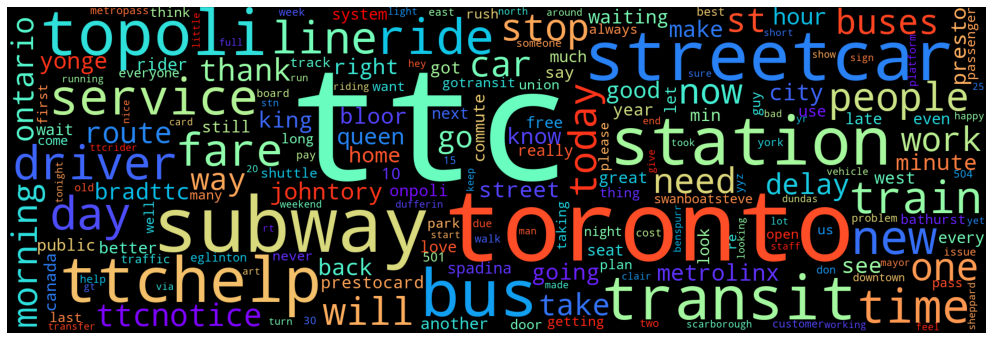

In [37]:
# initialize corpus of tweets
tweet_text = ''

# loop through tweets
for tweet in tweets.index:
    
    # get current tweet
    curr_tweet = tweets.loc[tweet, 'content']
    
    # add tweet to corpus
    tweet_text += curr_tweet + ' '
    
# convert to lower case
tweet_text = tweet_text.lower()

# make word cloud
wcloud = WordCloud(width = 1800, height = 600, random_state = 18, collocations = False, colormap = 'rainbow',
                   include_numbers = True, min_word_length = 2).generate(tweet_text)
plt.figure(figsize = (18, 6))
plt.imshow(wcloud)
plt.axis('off')
plt.show()

The word cloud essentially looks as expected. "Toronto" appears frequently in tweets, as do the TTC's various transit types of "bus", "streetcar", and "subway". Of these transit types it seems that many tweets relate to the subway system since the words "train", "line", "station" occur rather often.

### Trends Over Time

Let's look at trends over time, starting with a plot of the number of tweets per day.

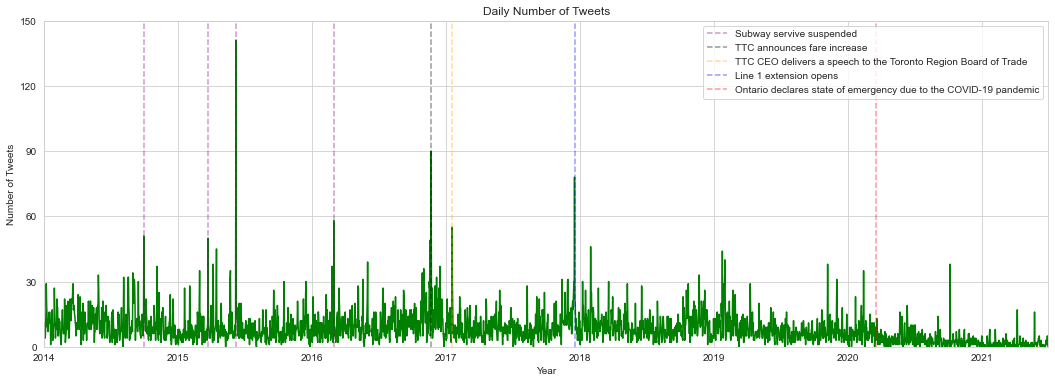

In [38]:
# get counts per day
tweets_per_day = tweets.groupby('date').count()['content'].reset_index()

# rename column
tweets_per_day.columns = ['date', 'numTweets']

# assign a count of 0 to dates without tweets
for date in pd.date_range(dt(2014, 1, 1), dt(2021, 6, 30)):
    if date.date() not in tweets_per_day['date'].values:
        temp_df = pd.DataFrame(data = {'date':[date.date()], 'numTweets':[0]})
        tweets_per_day = pd.concat([tweets_per_day, temp_df])

# reset index
tweets_per_day.reset_index(inplace = True, drop = True)

# sort by date
tweets_per_day.sort_values('date', inplace = True)

# important dates
no_sub_1 = dt(2015, 6, 8)
no_sub_2 = dt(2014, 9, 30)
no_sub_3 = dt(2015, 3, 24)
no_sub_4 = dt(2016, 3, 1)
fare_inc = dt(2016, 11, 21)
ceo_speech = dt(2017, 1, 17)
line_ext = dt(2017, 12, 17)
lockdown = dt(2020, 3, 17)

# make plot
alpha = 0.4
plt.figure(figsize = (18, 6))
fig = sns.lineplot(data = tweets_per_day, x = 'date', y = 'numTweets', color = 'g')
fig.set(title = 'Daily Number of Tweets', xlabel = 'Year', ylabel = 'Number of Tweets',
        xlim = [dt(2014, 1, 1), dt(2021, 7, 1)], ylim = [0, 150], yticks = np.arange(0, 180, 30))
plt.axvline(no_sub_1, color = 'purple', label = 'Subway servive suspended', ls = '--', alpha = alpha)
plt.axvline(no_sub_2, color = 'purple', ls = '--', alpha = alpha)
plt.axvline(no_sub_3, color = 'purple', ls = '--', alpha = alpha)
plt.axvline(no_sub_4, color = 'purple', ls = '--', alpha = alpha)
plt.axvline(fare_inc, color = 'black', label = 'TTC announces fare increase', ls = '--', alpha = alpha)
plt.axvline(ceo_speech, color = 'orange', label = 'TTC CEO delivers a speech to the Toronto Region Board of Trade', ls = '--',
            alpha = alpha)
plt.axvline(line_ext, color = 'b', label = 'Line 1 extension opens', ls = '--', alpha = alpha)
plt.axvline(lockdown, color = 'r', label = 'Ontario declares state of emergency due to the COVID-19 pandemic', ls = '--',
                alpha = alpha)
plt.legend()
plt.show()

There seems to be a constant baseline value of about 8 tweets per day but certain days have significantly more tweets. On June 8, 2015, [all four subway lines were suspended](https://globalnews.ca/news/2041558/all-ttc-subway-lines-suspended/) for over an hour due to a communications breakdown, leading to thousands of unhappy commuters. There are a number of other major subway service disruptions, such as on [September 30, 2014](https://toronto.ctvnews.ca/ttc-service-resumes-hours-after-subway-flooding-1.2031265), [March 24, 2015](https://toronto.citynews.ca/2015/03/24/spill-at-college-station-suspends-subway-service-bloor-to-union/), and on [March 1, 2016](https://twitter.com/ttcnotices/status/704619124656308228), just to name a few examples.

On November 21, 2016, the [TTC announced a ten cent fare increase](https://toronto.citynews.ca/2016/11/21/ttc-board-approves-10-cent-fare-hike-for-2017/), which was not very well-received by Torontonians.

Not all events leading to high Twitter activity are negative though. On December 17, 2017, the [TTC opened an extension of Line 1](https://www.ttc.ca/Coupler/Editorial/Special_Features/018_Jan_tysse_public_opening.jsp), extending TTC subway service to the York region. And on January 17, 2017, [TTC CEO Andy Byford delivered a speech to the Toronto Region Board of Trade](https://www.ttc.ca/Coupler/Editorial/News/017_Jan_TRBOT_CEO_speech.jsp), detailing his plans for the TTC moving forward.

Of course, one cannot ignore the COVID-19 pandemic and its effects on nearly every facet of life. On March 17, 2020, the government of Ontario [declared a state of emergency](https://globalnews.ca/news/6688074/ontario-doug-ford-coronavirus-covid-19-march-17/) due to the COVID-19 pandemic. From the graph above it seems as though the mean number of tweets appears to drop after this declaration and the number of tweets does not return to pre-COVID levels. Is there really a difference in the mean number of tweets during the COVID-19 pandemic?

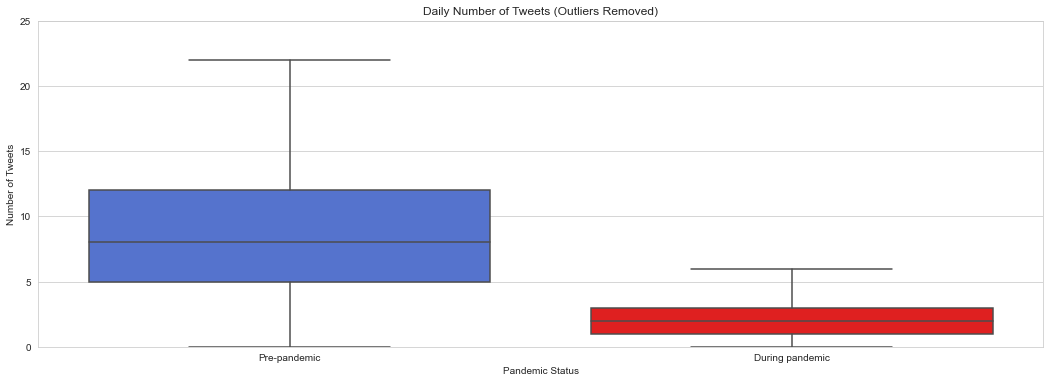

In [39]:
# create feature to record whether a given date is during the COVID-19 pandemic
tweets_per_day['pandemic'] = tweets_per_day['date'].apply(lambda x: 1 * (x >= lockdown.date()))

# make plot
plt.figure(figsize = (18, 6))
fig = sns.boxplot(data = tweets_per_day, x = 'pandemic', y = 'numTweets', showfliers = False, palette = {0:'royalblue', 1:'r'})
fig.set(title = 'Daily Number of Tweets (Outliers Removed)', xlabel = 'Pandemic Status', ylabel = 'Number of Tweets',
        ylim = [0, 25], xticklabels = ['Pre-pandemic', 'During pandemic'])
plt.show()

It certainly appears as though the mean number of tweets is much lower during the pandemic than it was before the pandemic. More explicitly, there were on average just over 9 tweets per day with the #TTC hashtag from the Toronto area but during the pandemic that number dropped to under 3 tweets per day. We use a Welch's t-test to verify that the difference in means is statistically significant. In this and all other statistical tests we adopt a significance level of 0.05.

In [40]:
# tweet counts
a = tweets_per_day[tweets_per_day['pandemic'] == 0]['numTweets']
b = tweets_per_day[tweets_per_day['pandemic'] == 1]['numTweets']

# perform Welch's t-test
pval = stats.ttest_ind(a, b, equal_var = False).pvalue

# print p-value
print("Welch's t-test p-value: {:.2e}".format(pval))

Welch's t-test p-value: 2.40e-180


We can safely conclude that the mean number of tweets during the COVID-19 pandemic is less than the mean number of tweets before the pandemic. This is likely due to reduced TTC ridership during the pandemic.

We know that the COVID-19 pandemic affected the long-term number of daily tweets with drastically reduced numbers in 2020 and 2021. But what if we consider shorter time scales? What if we look at the number of tweets by the day of the week?

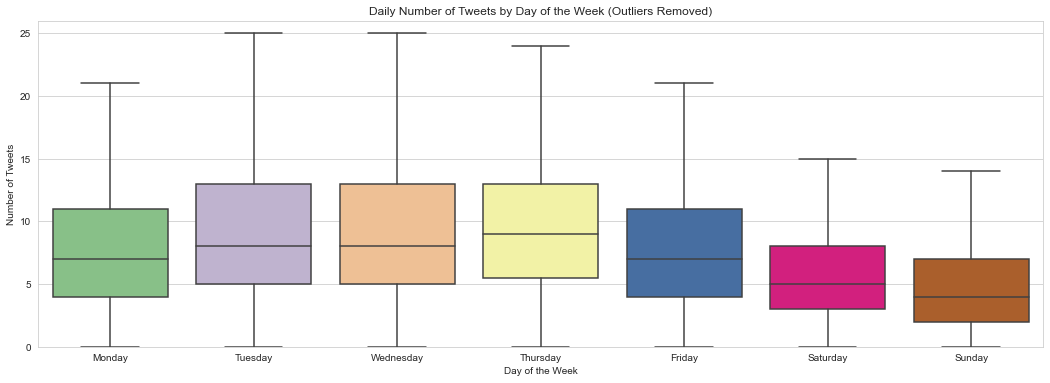

In [41]:
# create "day of the week" feature
tweets_per_day['dayOfWeek'] = tweets_per_day['date'].apply(lambda x: calendar.day_name[x.weekday()])

# list of days
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# make plot
plt.figure(figsize = (18, 6))
fig = sns.boxplot(data = tweets_per_day, x = 'dayOfWeek', y = 'numTweets', showfliers = False, palette = 'Accent', order = days)
fig.set(title = 'Daily Number of Tweets by Day of the Week (Outliers Removed)', xlabel = 'Day of the Week',
        ylabel = 'Number of Tweets', ylim = [0, 26])
plt.show()

It appears as though there are noticeably fewer tweets on weekends. Among the weekdays we find that there seem to be slightly fewer tweets on Mondays and Fridays as well. Let's verify that there is indeed a statistically significant difference using a Kruskal-Wallis H-test.

In [42]:
# initialize dictionary of tweet counts
count_by_weekday = dict()

# loop through days
for day in days:
    
    # store tweet counts
    count_by_weekday[day] = tweets_per_day[tweets_per_day['dayOfWeek'] == day]['numTweets']
    
# perform Kruskal-Wallis H-test
pval = stats.kruskal(count_by_weekday[days[0]], count_by_weekday[days[1]], count_by_weekday[days[2]], count_by_weekday[days[3]],
                     count_by_weekday[days[4]], count_by_weekday[days[5]], count_by_weekday[days[6]]).pvalue

# print p-value
print('Kruskal-Wallis H-test p-value: {:.2e}'.format(pval))

Kruskal-Wallis H-test p-value: 6.11e-52


The Kruskal-Wallis H-test confirms that there is a statistically significant difference in the mean daily number of tweets when we group by the day of the week. Let's apply Welch's t-tests to determine which pairs of days differ. We use a Holm-Bonferroni correction to account for multiplicity.

In [43]:
# initialize list of day-pairs and p-values
pairs = []
pvals = []

# loop through all pairs of days
for i in days:
    for j in days:
        if i < j:
            
            # apply Welch's t-test
            pval = stats.ttest_ind(count_by_weekday[i], count_by_weekday[j], equal_var = False).pvalue
            
            # append day-pair and p-value
            pairs.append((i, j))
            pvals.append(pval)
            
# initialize list to store pairs with statistically significant differences
diff_pairs = []

# apply Holm-Bonferroni correction
hb = multipletests(pvals, method = 'holm')[0]

# loop through day-pairs
for i in range(len(pairs)):
    
    # check for pairs with statistically significant differences
    if hb[i]:
        
        # append to list of pairs
        diff_pairs.append(pairs[i])
        
# print pairs with statistically significant differences
print('Pairs of days with statistically significant differences:')
for pair in diff_pairs:
    print(pair)

Pairs of days with statistically significant differences:
('Monday', 'Saturday')
('Monday', 'Sunday')
('Friday', 'Tuesday')
('Friday', 'Thursday')
('Friday', 'Saturday')
('Friday', 'Sunday')
('Saturday', 'Tuesday')
('Saturday', 'Wednesday')
('Saturday', 'Thursday')
('Sunday', 'Tuesday')
('Sunday', 'Wednesday')
('Sunday', 'Thursday')


We find that Saturday and Sunday have statistically significant differences with every weekday. Thus we conclude that weekends tend to have fewer daily tweets than weekdays, with weekdays averaging over 9 tweets per day and weekends just under 6 tweets daily.

Now let's look at even shorter time scales. At what time of day are tweets typically tweeted?

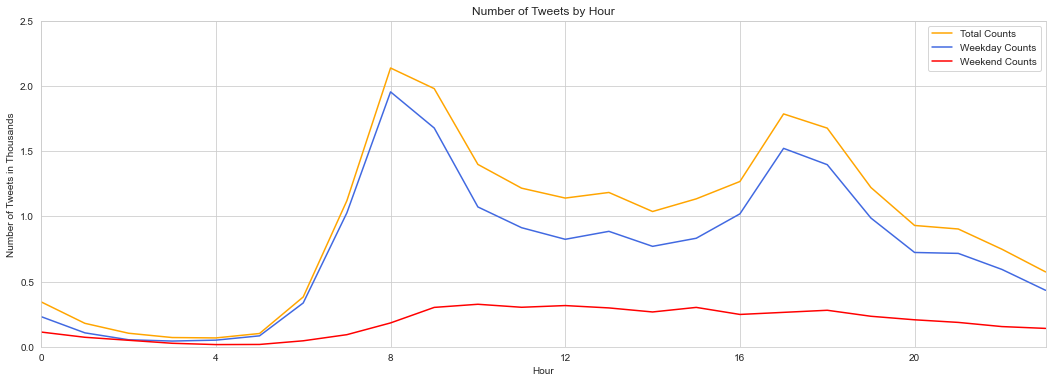

In [44]:
# separate by weekday vs weekend
weekday = tweets[~tweets['dayOfWeek'].isin(['Saturday', 'Sunday'])]
weekend = tweets[tweets['dayOfWeek'].isin(['Saturday', 'Sunday'])]
    
# get counts per hour
tweets_per_hour = tweets.groupby('hour').count()['date'].reset_index()
counts_weekday = weekday.groupby('hour').count()['date'].reset_index()
counts_weekend = weekend.groupby('hour').count()['date'].reset_index()

# loop through dataframes
hour_dfs = [tweets_per_hour, counts_weekday, counts_weekend]
for df in hour_dfs:
    
    # rename columns
    df.columns = ['hour', 'numTweets']

    # record counts in thousands
    df['numTweets'] /= 1000
    
# make plot
plt.figure(figsize = (18, 6))
fig = sns.lineplot(data = tweets_per_hour, x = 'hour', y = 'numTweets', label = 'Total Counts', color = 'orange')
sns.lineplot(data = counts_weekday, x = 'hour', y = 'numTweets', label = 'Weekday Counts', color = 'royalblue')
sns.lineplot(data = counts_weekend, x = 'hour', y = 'numTweets', label = 'Weekend Counts', color = 'r')
fig.set(title = 'Number of Tweets by Hour', xlabel = 'Hour', ylabel = 'Number of Tweets in Thousands', xlim = [0, 23],
        ylim = [0, 2.5], xticks = np.arange(0, 24, 4))
plt.legend()
plt.show()

On weekdays we find two peak Twitter times: one at 8 am and the other at 5 pm, which not so coincidentally aligns with typical commuting hours. On weekends there are no such peaks and instead the tweet output is roughly constant from 9 am to around 6 pm. Unsurprisingly there are very few tweets between the hours of 2 am and 5 am.

So far we have found that there are some clear patterns pertaining to how the number of daily tweets changes over time. What if we instead consider the mean daily sentiment score instead? Let's have a look at the distribution of sentiment scores in our dataset.

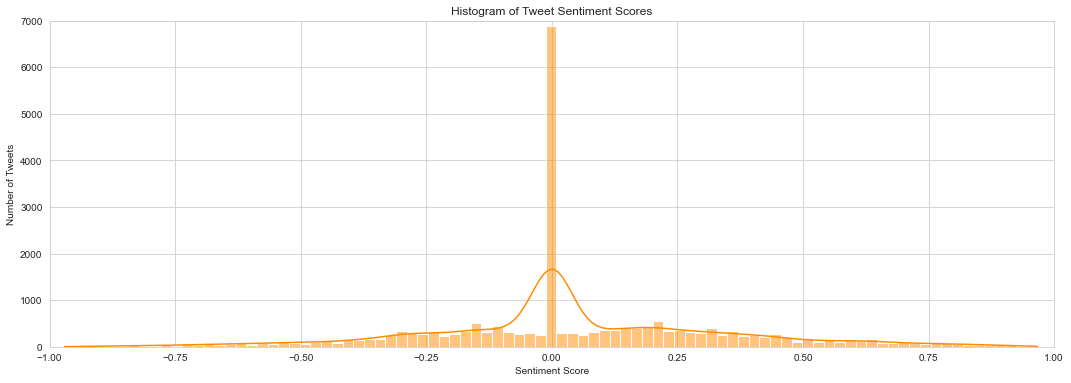

In [45]:
# make plot
plt.figure(figsize = (18, 6))
fig = sns.histplot(data = tweets, x = 'score', kde = True, color = 'darkorange')
fig.set(title = 'Histogram of Tweet Sentiment Scores', xlabel = 'Sentiment Score', ylabel = 'Number of Tweets', xlim = [-1, 1],
        ylim = [0, 7000])
plt.show()

A substantial proportion of tweets are neutral, evidenced by the massive spike in the histogram at a sentiment score of 0. Let's zoom in to get a better sense of the histogram in the regions away from 0.

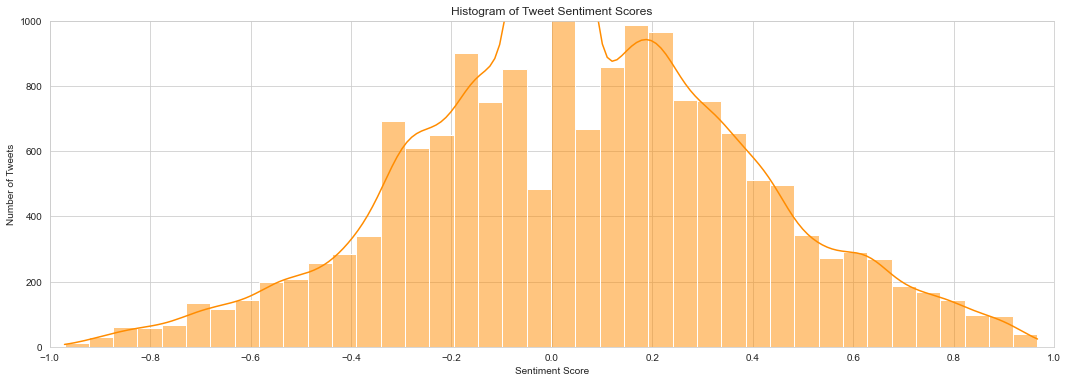

In [46]:
# make plot
plt.figure(figsize = (18, 6))
fig = sns.histplot(data = tweets, x = 'score', kde = True, bins = 40, color = 'darkorange')
fig.set(title = 'Histogram of Tweet Sentiment Scores', xlabel = 'Sentiment Score', ylabel = 'Number of Tweets', xlim = [-1, 1],
        ylim = [0, 1000], xticks = np.arange(-1, 1.2, 0.2))
plt.show()

The distribution of sentiment scores appears trimodal: one rather large peak at 0 for the neutral tweets, a small second peak at around 0.2 for the positive tweets, and a third peak at about -0.2 for the negative tweets.

It is a little difficult to tell from the histogram alone but it appears as though there are slightly more positive tweets than negative ones.

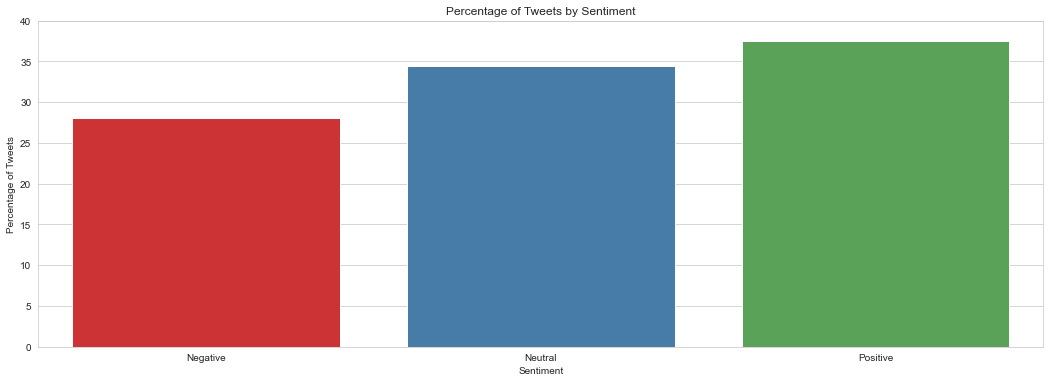

In [47]:
# compute percentages
perc = tweets['sentiment'].value_counts().reset_index()
perc['sentiment'] *= 100 / tweets.shape[0]

# rename columns
perc.columns = ['Sentiment', 'Percentage of Tweets']

# make plot
sentiments = ['Negative', 'Neutral', 'Positive']
plt.figure(figsize = (18, 6))
fig = sns.barplot(data = perc, x = 'Sentiment', y = 'Percentage of Tweets', palette = 'Set1')
fig.set(title = 'Percentage of Tweets by Sentiment', ylim = [0, 40], xticklabels = sentiments)
plt.show()

The classes are pretty evenly balanced. About 38% of tweets are positive, 34% are neutral, and roughly 28% are negative. I must admit that I am a bit surprised at this as I initially thought that Torontonians were not terribly fond of the TTC. I anticipated that these negative emotions would manifest as negative tweets.

Now that we have an idea of the sentiment distribution in our dataset let's take a look at the mean daily sentiment over time.

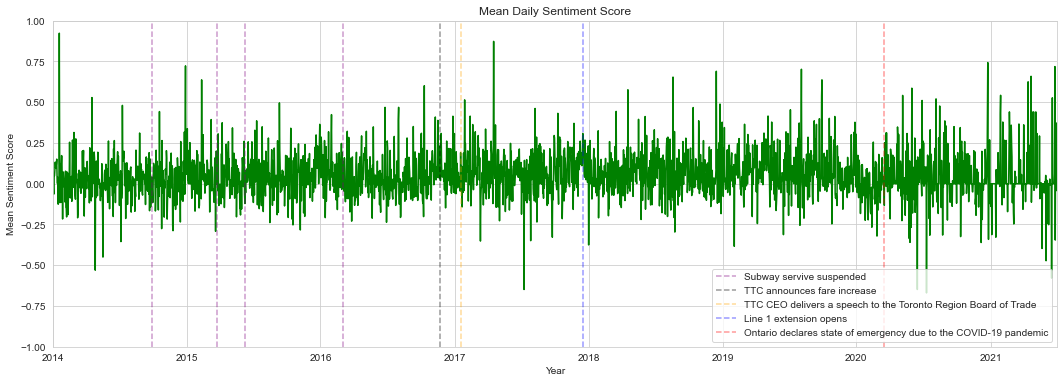

In [48]:
# get mean score per day
score_per_day = tweets.groupby('date').mean()['score'].reset_index()

# assign a score of 0 to dates without tweets
for date in pd.date_range(dt(2014, 1, 1), dt(2021, 6, 30)):
    if date.date() not in score_per_day['date'].values:
        temp_df = pd.DataFrame(data = {'date':[date.date()], 'score':[0]})
        score_per_day = pd.concat([score_per_day, temp_df])

# reset index
score_per_day.reset_index(inplace = True, drop = True)

# sort by date
score_per_day.sort_values('date', inplace = True)

# merge with the tweets_per_day dataframe
tweets_per_day = pd.merge(tweets_per_day, score_per_day, on = 'date')

# make plot
plt.figure(figsize = (18, 6))
fig = sns.lineplot(data = tweets_per_day, x = 'date', y = 'score', color = 'g')
fig.set(title = 'Mean Daily Sentiment Score', xlabel = 'Year', ylabel = 'Mean Sentiment Score',
        xlim = [dt(2014, 1, 1), dt(2021, 7, 1)], ylim = [-1, 1])
plt.axvline(no_sub_1, color = 'purple', label = 'Subway servive suspended', ls = '--', alpha = alpha)
plt.axvline(no_sub_2, color = 'purple', ls = '--', alpha = alpha)
plt.axvline(no_sub_3, color = 'purple', ls = '--', alpha = alpha)
plt.axvline(no_sub_4, color = 'purple', ls = '--', alpha = alpha)
plt.axvline(fare_inc, color = 'black', label = 'TTC announces fare increase', ls = '--', alpha = alpha)
plt.axvline(ceo_speech, color = 'orange', label = 'TTC CEO delivers a speech to the Toronto Region Board of Trade', ls = '--',
            alpha = alpha)
plt.axvline(line_ext, color = 'b', label = 'Line 1 extension opens', ls = '--', alpha = alpha)
plt.axvline(lockdown, color = 'r', label = 'Ontario declares state of emergency due to the COVID-19 pandemic', ls = '--',
                alpha = alpha)
plt.legend()
plt.show()

The graph above is quite different from the graph of the daily number of tweets. In the first plot of daily number of tweets we found large spikes on certain days, such as when the Line 1 extension opened or days with subway issues. However, in the plot of mean daily sentiment these days are unremarkable. Quite unexpectedly, there are no steep dips in sentiment on days with unexpected subway issues, nor is there a sharp increase in sentiment on the day the Line 1 extension opened. If the spikes and dips do not correspond to the same spikes and dips in the daily tweet count plot, then what do they correspond to? Let's have a look at the tweets from the days with the ten highest mean sentiment scores.

In [49]:
# days with the most positive mean sentiment scores
most_pos = tweets_per_day.sort_values('score', ascending = False).head(10)['date'].values

# tweets from the most positive days
tweets[tweets['date'].isin(most_pos)][['date', 'content', 'username', 'score']]

,date,content,username,score
9,2021-06-25,"This is surplus #TTC land, and will have some #AffordableHousing units for Seniors via the OPEN DOOR program in #TOPoli… this is the first site to partner with a Long-Term Care (LTC) charity.",HousingNowTO,0.71840
99,2021-04-21,"@SabiVM @DrSamirSinha @MCISLanguages Great work, Sabina…it reminds me of translating the #TTC’s printed Ride Guide into 17 languages, to serve some of Toronto’s language minorities, &, getting its supplier, MapArt to produce the web version as a single expandable .pdf, rather than 35 tiles in proprietary format!",BobBrentTO,0.65880
257,2020-12-24,It's Throwback #tbt❤️ Thursday words of the day Toronto Transit Commission #ttc #teatalktoronto #sipandspilldatea #the6ix #COVID2019 #socialmedia #happyholidays #subwaystation,Stopandimagine1,0.74300
2709,2019-08-04,Toronto Caribbean Carnival TTC service map #toronto #torontocaribbeanfestival #caribana #ttc #exhibitionplace #maps #map @ Bloor–Yonge station,randyfmcdonald,0.49390
2710,2019-08-04,#Toronto #Transit #PeaceOfficers #TTC #SpecialConstable Services #PublicTransit #PublicSafety #PeaceOfficer #longweekend #caribana2019 #CaribanaToronto #carnival2019 #Caribana2019 #carnival,Transit30165,0.91000
4688,2018-12-15,Well this is a beautiful video! Love our #TTC musicians.,selinayoung,0.68965
5945,2018-08-19,This is what it looks like when #TTC transit operators make your child’s day awesome #honk&wave #jumpsofjoy @bradTTC,JuliaKassam,0.88600
5946,2018-08-19,NOT BAY - Brilliant marketing by The Abnormal Beauty Company @deciem #notbay #notbaystation #deciem #beauty #cheaky #yorkville #toronto #downtown #transit #ttc #subway #thebetterway…,photorialist,0.81400
5947,2018-08-19,Age Group Gold medal at the @multisportcan Toronto Island Duathlon! Title defended! . . #duathlon #ttc #ttcracing #multisport #runbikerun #winner #goldmedal #torontoisland…,PigsCanFlyHigh1,0.26200
10608,2017-04-17,"Watching @MapleLeafs at a bar / @AirCanadaCentre, with #friends + #drinks? Plan a #SAFE way home: #walk #ttc #taxi #PhoneAFriend #GoLeafsGo",TPSAux13Div,0.87300


Positive tweets do not seem to relate to any particular TTC-specific events. They range from those expressing satisfaction with TTC employees to a tweet about enjoying a Leafs game with friends to a few regarding the Toronto Caribbean Carnival.

Now we look at the ten days with the most negative mean sentiment score.

In [50]:
# days with the most negative mean sentiment scores
most_neg = tweets_per_day.sort_values('score').head(10)['date'].values

# tweets from the most negative days
tweets[tweets['date'].isin(most_neg)][['date', 'content', 'username', 'score']]

,date,content,username,score
15,2021-06-16,No one: TTC streetcars: I’m just gonna stop here for no reason and won’t tell anybody why. #TTC #BrokenTTC,OnePabloJar,-0.578750
41,2021-06-01,"Spotted early Sunday morning hanging off the front of a TTC bus at Queen & Spadina: a racist trash bag bold enough to spew hate, but too scared to show her face. Kudos to the man for keeping his composure while dealing with this crap. @TTChelps #TTC #StopAsianHate #Toronto",Mirandanthistle,-0.472300
68,2021-05-21,"#TTC With all the streetcar diversions, subway shut downs, Presto failures and lack of communication to your customers, WHY ARE YOU STILL OPERATING? We need alternatives! #TTCFAIL",Dragonstar67,-0.396967
714,2020-07-10,And it wouldn't be so bad if #TTC transitvdjdn't duck right now.,redjane,-0.669600
825,2020-06-15,"@ahmedelgeneidy @regionomics @mcgillu @jamietdeweese @hdemyk @LeilaHawa1 @ABelikow @ZaneDavey5 NB @ShelleyCarroll @IamDavidMiller @M_Layton @Ainslie_Ward24 If I'm reading the #Toronto graph correctly, the lower income accounted for a much higher % of #TTC rides (than higher income), during the Covid-19🦠impact, therefore they bore the majority of the service cut impacts.",BobBrentTO,-0.648600
4145,2019-02-02,"@thewaywardrose City of Toronto - @TO_Transport & #TTC - should just go ""full NYC"" and designate Streetcar Routes & Bus-Lanes as ""SNOW EMERGENCY ROUTES"" with NO PARKING 24/7 - and Mandatory Towing until the Snow is Cleared. #TOPoli Seriously, @JohnTory - #GetTorontoMoving please..!",mjrichardson_to,-0.462750
4146,2019-02-02,"@SwanBoatSteve @TTChelps City of Toronto - @TO_Transport & #TTC - should just go ""full NYC"" and designate Streetcar Routes & Bus-Lanes as ""SNOW EMERGENCY ROUTES"" with NO PARKING 24/7 - and Mandatory Towing until the Snow is Cleared. #TOPoli",mjrichardson_to,-0.338700
4147,2019-02-02,Terrible picture of parked SUV on Gerrard St E blocking multiple streetcars. Make streetcar lines No Parking Zones! Canada #TOpoli #TTC,SheilaR,-0.350100
8104,2018-01-01,"@SwanBoatSteve This is particularly true with outrageously overbuilt, fiscally irresponsible #TTC expansion projects (eg. #SmartTrack, #SSE) where Mayor, Staff are pushing (re-election) CAPEX approvals w/o disclosure of their devastating Operating Expense impacts!",BobBrentTO,-0.375300
9844,2017-07-09,@TTCing lining up for #TTC NORTHBOUND bus - long line is from Park Road to Yonge/Bloor #unacceptable #delay,Alex_M_Zamora,-0.648600


Just as was the case with the positive tweets, the tweets from the most negative days do not pertain to any particular events but rather just general frustration with the TTC.

Another aspect in which the plot of mean daily sentiment score differs from the plot of daily number of tweets is that the COVID-19 pandemic appears to have no impact on sentiment.

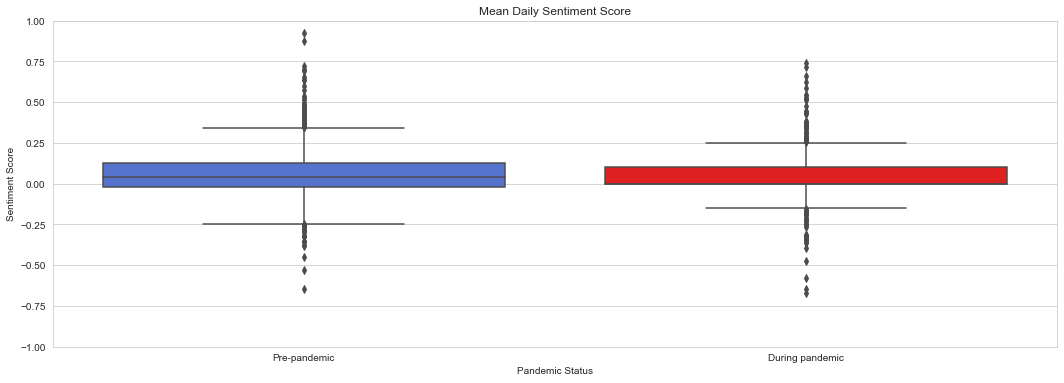

In [51]:
# make plot
plt.figure(figsize = (18, 6))
fig = sns.boxplot(data = tweets_per_day, x = 'pandemic', y = 'score', palette = {0:'royalblue', 1:'r'})
fig.set(title = 'Mean Daily Sentiment Score', xlabel = 'Pandemic Status', ylabel = 'Sentiment Score', ylim = [-1, 1],
        xticklabels = ['Pre-pandemic', 'During pandemic'])
plt.show()

From the box plot it really does seem as though there is essentially no difference in mean daily sentiment score when comparing tweets from before the pandemic to tweets during the pandemic. Let's apply a Welch's t-test to be sure.

In [52]:
# mean sentiment
a = tweets_per_day[tweets_per_day['pandemic'] == 0]['score']
b = tweets_per_day[tweets_per_day['pandemic'] == 1]['score']

# apply Welch's t-test
pval = stats.ttest_ind(a, b, equal_var = False).pvalue

# print p-value
print("Welch's t-test p-value: {:.2e}".format(pval))

Welch's t-test p-value: 8.20e-02


With our significance level of 0.05 we can **not** conclude that there is a statistically significant difference in means in mean daily sentiment score when comparing pre-COVID tweets to tweets during the pandemic.

Now let's take a look at the mean daily sentiment score by day of the week.

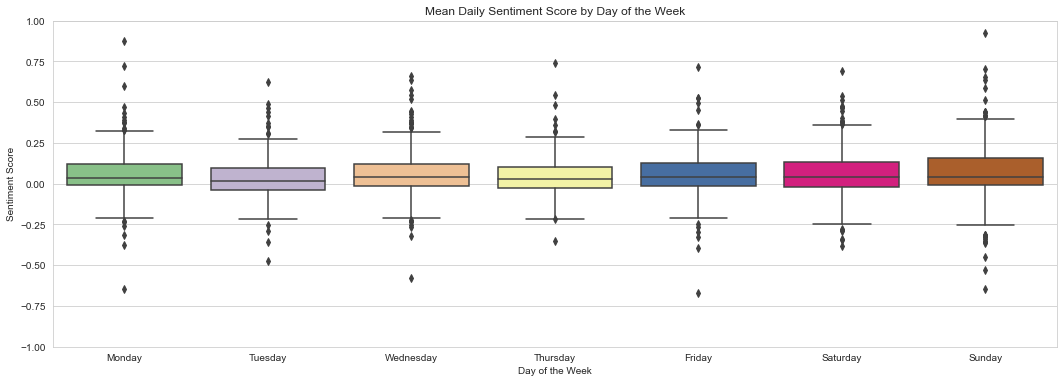

In [53]:
# make plot
plt.figure(figsize = (18, 6))
fig = sns.boxplot(data = tweets_per_day, x = 'dayOfWeek', y = 'score', palette = 'Accent', order = days)
fig.set(title = 'Mean Daily Sentiment Score by Day of the Week', xlabel = 'Day of the Week', ylabel = 'Sentiment Score',
        ylim = [-1, 1])
plt.show()

In contrast with our box plot of daily number of tweets by day of the week, we observe that there appears to be no difference in mean daily sentiment score when we group by the day of the week. We perform a Kruskal-Wallis H-test to check this claim.

In [54]:
# initialize dictionary of mean scores
score_by_weekday = dict()

# loop through days
for day in days:
    
    # store tweet counts
    score_by_weekday[day] = tweets_per_day[tweets_per_day['dayOfWeek'] == day]['score']
    
# perform Kruskal-Wallis H-test
pval = stats.kruskal(score_by_weekday[days[0]], score_by_weekday[days[1]], score_by_weekday[days[2]], score_by_weekday[days[3]],
                     score_by_weekday[days[4]], score_by_weekday[days[5]], score_by_weekday[days[6]]).pvalue

# print p-value
print('Kruskal-Wallis H-test p-value: {:.2e}'.format(pval))

Kruskal-Wallis H-test p-value: 1.47e-02


Despite appearances, the Kruskal-Wallis H-test does detect a statistically significant difference in mean daily sentiment scores when grouping by day of the week. As before, we apply Welch's t-tests with a Holm-Bonferroni correction to ascertain which pairs of days differ.

In [55]:
# initialize list of day-pairs and p-values
pairs = []
pvals = []

# loop through all pairs of days
for i in days:
    for j in days:
        if i < j:
            
            # apply Welch's t-test
            pval = stats.ttest_ind(score_by_weekday[i], score_by_weekday[j], equal_var = False).pvalue
            
            # append day-pair and p-value
            pairs.append((i, j))
            pvals.append(pval)
            
# initialize lists to store pairs with statistically significant differences
diff_pairs = []

# apply Holm-Bonferroni correction
hb = multipletests(pvals, method = 'holm')[0]

# loop through day-pairs
for i in range(len(pairs)):
    
    # check for pairs with statistically significant differences
    if hb[i]:
        
        # append to list of pairs
        diff_pairs.append(pairs[i])
        
# print pais with statistically significant differences
print('Pairs of days with statistically significant differences:')
for pair in diff_pairs:
    print(pair)

Pairs of days with statistically significant differences:


Despite the Kruskal-Wallis H-test showing the existence of a pair of weekdays with statistically significant differences in mean daily sentiment score when grouping by day of the week, we actually find no such pairs.

As our analogue to the number of tweets by hour, let's plot the mean sentiment score by hour.

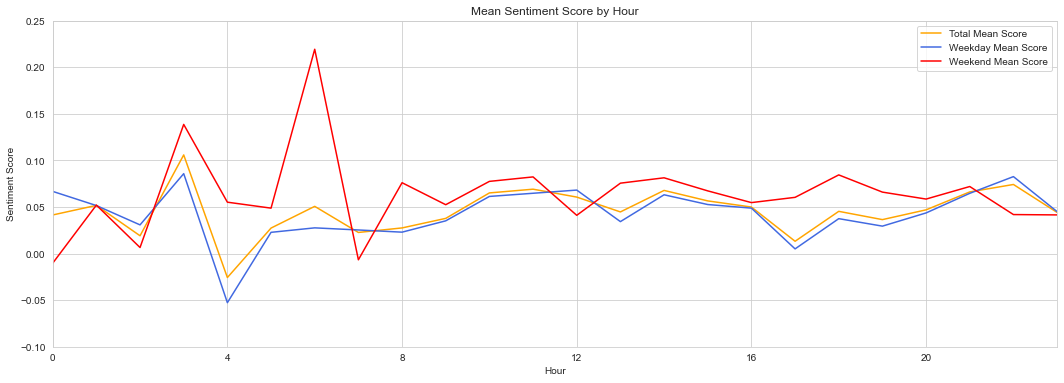

In [56]:
# get mean score per hour
score_per_hour = tweets.groupby('hour').mean()['score'].reset_index()
score_weekday = weekday.groupby('hour').mean()['score'].reset_index()
score_weekend = weekend.groupby('hour').mean()['score'].reset_index()

# make plot
plt.figure(figsize = (18, 6))
fig = sns.lineplot(data = score_per_hour, x = 'hour', y = 'score', label = 'Total Mean Score', color = 'orange')
sns.lineplot(data = score_weekday, x = 'hour', y = 'score', label = 'Weekday Mean Score', color = 'royalblue')
sns.lineplot(data = score_weekend, x = 'hour', y = 'score', label = 'Weekend Mean Score', color = 'r')
fig.set(title = 'Mean Sentiment Score by Hour', xlabel = 'Hour', ylabel = 'Sentiment Score', xlim = [0, 23],
        ylim = [-0.1, 0.25], xticks = np.arange(0, 24, 4))
plt.legend()
plt.show()

There is no discernible trend when we consider mean sentiment scores by hour. However, we do note a sharp increase in sentiment score on weekends around 6 am. There is also a small peak in sentiment scores for tweets from about 3 am.

Unlike the daily number of tweets it looks like mean daily sentiment score is not affected by much. I suspect I already know the answer but is there a relationship between the number of tweets in a day and that day's mean sentiment score?

In [57]:
# correlation value
corr = tweets_per_day.corr().loc['numTweets', 'score']

# print correlation
print('Correlation value between the number of daily tweets and the daily mean sentiment score: {}'.format(round(corr, 3)))

Correlation value between the number of daily tweets and the daily mean sentiment score: -0.042


There is essentially no correlation between the number of tweets in a day and the daily mean sentiment score. Our exploration with the sentiment score may seem disheartening as it might suggest that Twitter sentiment is not really related to any external factors. However, if we consider the sentiment rather than the sentiment score then we will indeed be able to find some interesting relationships.

### **replyCount**, **retweetCount**, **likeCount**, and **quoteCount**

Are positive tweets more liked than negative ones? Are they more often retweeted? Perhaps less often? Let's answer these questions and others by exploring the **replyCount**, **retweetCount**, **likeCount**, and **quoteCount** features. We start with some summary statistics.

In [58]:
# list of features
tweet_metrics = ['replyCount', 'retweetCount', 'likeCount', 'quoteCount']

# summary statistics
tweets[tweet_metrics].describe([0.25, 0.5, 0.75, 0.99])

,replyCount,retweetCount,likeCount,quoteCount
count,22699.000000,22699.000000,22699.00000,22699.000000
mean,0.394687,0.670118,2.00141,0.096877
std,1.319165,5.384542,24.67587,1.427731
min,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.00000,0.000000
50%,0.000000,0.000000,0.00000,0.000000
75%,1.000000,0.000000,1.00000,0.000000
99%,4.000000,9.000000,26.00000,2.000000
max,134.000000,662.000000,3366.00000,161.000000


More than half of all tweets have no replies, retweets, or likes, nor are they quoted. By contrast, a select few tweets are replied to and/or liked very often, with the most popular tweet being liked thousands of times. Let's visualize this with some scatter plots.

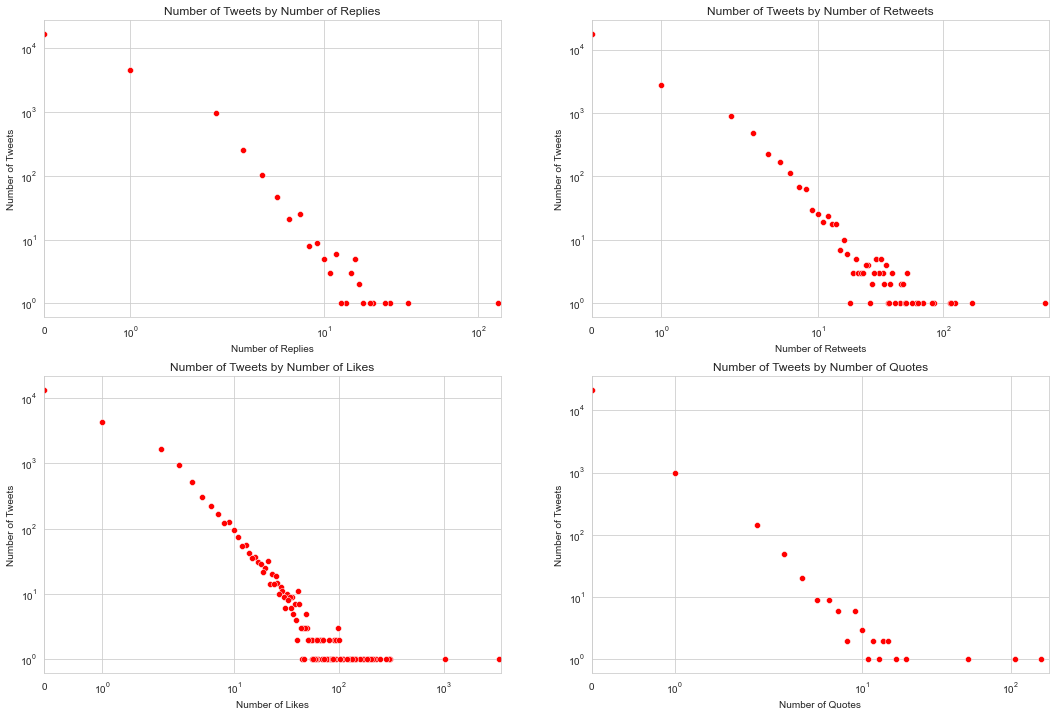

In [59]:
# graph parameters
names = {'replyCount':'Replies', 'retweetCount':'Retweets', 'likeCount':'Likes', 'quoteCount':'Quotes'}
xlims = {'replyCount':[0, 140], 'retweetCount':[0, 700], 'likeCount':[0, 3500], 'quoteCount':[0, 180]}

# initialize figure
plt.figure(figsize = (18, 12))
i = 1

# loop through features
for feat in tweet_metrics:
    
    # make plot
    plt.subplot(2, 2, i)
    fig = sns.scatterplot(data = tweets[feat].value_counts(), color = 'r')
    fig.set(title = 'Number of Tweets by Number of {}'.format(names[feat]), xlabel = 'Number of {}'.format(names[feat]),
            ylabel = 'Number of Tweets', xscale = 'symlog', yscale = 'log', xlim = xlims[feat])
    
    # increment counter
    i += 1
    
# display plots
plt.show()

Do any of these features correlate with sentiment?

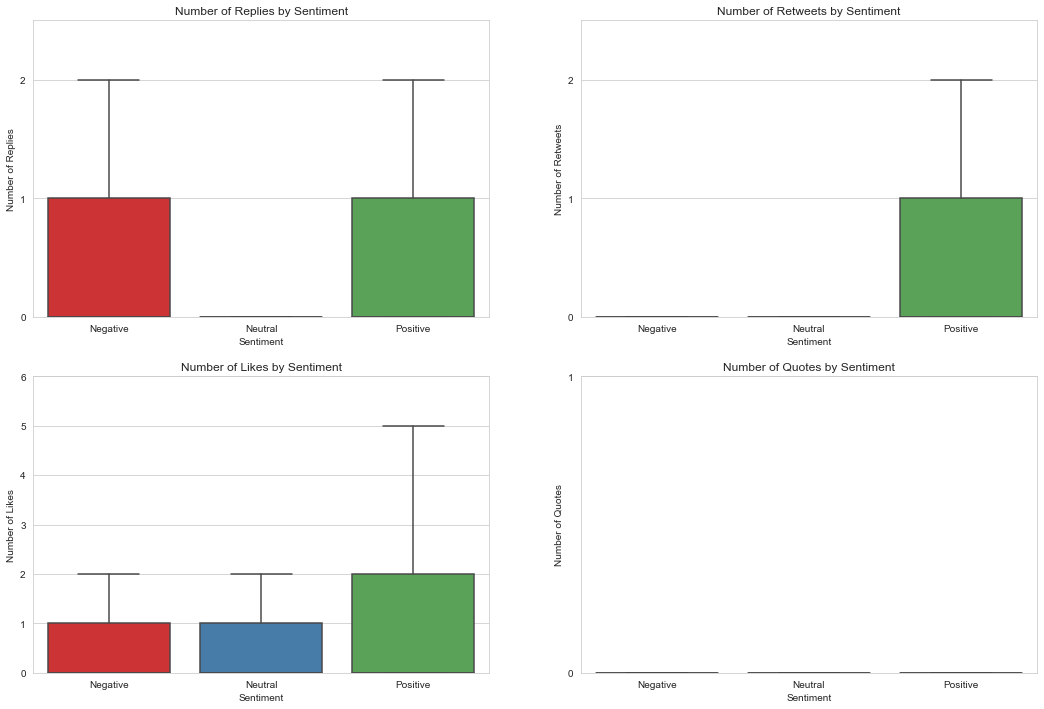

In [60]:
# graph parameters
ylims = {'replyCount':[0, 2.5], 'retweetCount':[0, 2.5], 'likeCount':[0, 6], 'quoteCount':[0, 1]}

# initialize figure
plt.figure(figsize = (18, 12))
i = 1

# loop through features
for feat in tweet_metrics:
    
    # make plot
    plt.subplot(2, 2, i)
    fig = sns.boxplot(data = tweets, x = 'sentiment', y = feat, showfliers = False, palette = 'Set1')
    fig.set(title = 'Number of {} by Sentiment'.format(names[feat]), xlabel = 'Sentiment', ylabel = 'Number of {}'.format(names[feat]),
            ylim = ylims[feat], yticks = np.arange(0, ylims[feat][1] + 0.5), xticklabels = sentiments)
    
    # increment counter
    i += 1
    
# display plots
plt.show()

From the box plot it seems as though the number of replies a tweet gets is independent of whether it is positive or negative. However, having some sentiment, be it positive or negative, appears to be important in determining how many replies a tweet receives.

We also note that positive tweets seem to be retweeted and liked more often than negative tweets.

Since tweets are quoted so infrequently the **quoteCount** feature is not that useful.

Let's verify our suspicions via Welch's t-tests. For **replyCount** we check whether there is a difference between neutral tweets and non-neutral tweets while for the other features we only check for differences between negative tweets and positive ones.

In [61]:
# loop through features
for feat in tweet_metrics:
    
    # check if feature is replyCount
    if feat == 'replyCount':
        
        # get counts
        a = tweets[tweets['sentiment'] != 0][feat]
        b = tweets[tweets['sentiment'] == 0][feat]
    
    # for other features
    else:
        
        # get counts
        a = tweets[tweets['sentiment'] == 1][feat]
        b = tweets[tweets['sentiment'] == -1][feat]
        
    # apply Welch's t-test
    pval = stats.ttest_ind(a, b, equal_var = False).pvalue
    
    # print p-value
    print('\n')
    print("Welch's t-test p-value for number of {}: {:.2e}".format(names[feat].lower(), pval))



Welch's t-test p-value for number of replies: 7.02e-10


Welch's t-test p-value for number of retweets: 2.86e-03


Welch's t-test p-value for number of likes: 2.19e-04


Welch's t-test p-value for number of quotes: 1.74e-01


The results of the first three tests are statistically significant. As anticipated from the box plots, we find that tweets with sentiment on average get more replies than those without. Explictly, tweets with sentiment, be it positive or negative, receive on average 0.43 replies per tweet while neutral tweets receive on average 0.33 replies per tweet. So while the difference is statistically significant, the effect size is quite small.

We also find that positive tweets get more retweets and likes, on average, than negative ones. Positive tweets get on average 0.85 retweets and 2.93 likes whereas negative tweets receive roughly 0.56 retweets and 1.33 likes on average. Overall, positive tweets seem to generate more engagement on average than negative tweets.

### **sourceLabel**

Next up we examine the **sourceLabel** feature, which records the type of device from which the tweet originated, e.g. iPhone, Android, etc. We first take a look at the distribution of the **sourceLabel** values.

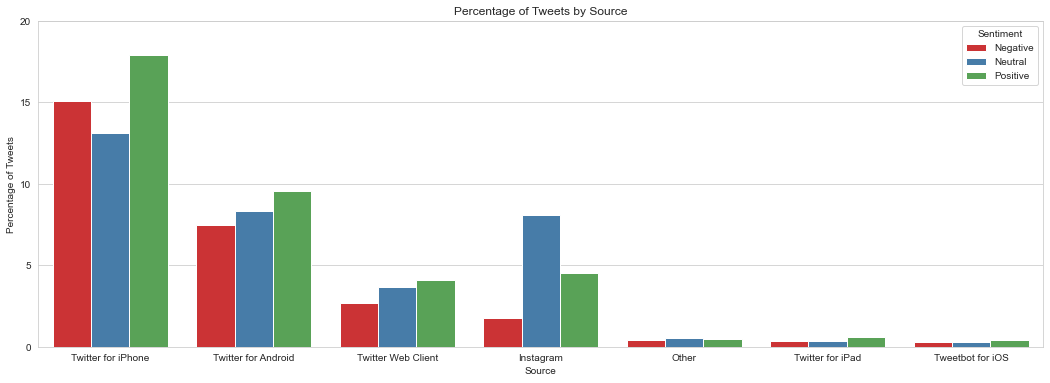

In [62]:
# initialize variables
first = True
sent_dict = {-1:'Negative', 0:'Neutral', 1:'Positive'}

# loop through sentiments
for sent in [-1, 0, 1]:
    
    # compute percentages
    temp_df = tweets[tweets['sentiment'] == sent]['sourceLabel'].value_counts().reset_index()
    temp_df['sourceLabel'] *= 100 / tweets.shape[0]
    
    # rename columns
    temp_df.columns = ['Source', 'Percentage of Tweets']
    
    # add feature recording sentiment
    temp_df['Sentiment'] = sent_dict[sent]
    
    # concatenate dataframes
    if first:
        perc = temp_df
        first = False
    else:
        perc = pd.concat([perc, temp_df]).reset_index(drop = True)

# make plot
plt.figure(figsize = (18, 6))
fig = sns.barplot(data = perc, x = 'Source', y = 'Percentage of Tweets', hue = 'Sentiment', palette = 'Set1')
fig.set(title = 'Percentage of Tweets by Source', ylim = [0, 20], yticks = np.arange(0, 25, 5))
plt.show()

A plurality of tweets come from iPhone users, accounting for about 46% of our tweets. Android users are the second-most common Twitter users, making up about a quarter of the dataset. Instagram users form approximately 14% of the dataset and users of the Twitter Web Client account for about a tenth of the tweets. Twitter for iPad, Tweetbot for iOS, and other sources are roughly equal in number and constitute the remainder.

The sentiment distribution appears to differ between sources. For iPhone and Tweetbot users, most tweets are positive and neutral tweets are the least common. For users who tweet from Android devices, web browsers, or iPads we find that positive tweets are the most common and negative tweets are the least common. Lastly, the situation is quite different for Instagram users which have the bulk of their tweets classified as neutral. Thus it does appear as though the tweet source is related to sentiment. Let's verify this with a chi-squared test.

In [63]:
# restrict attention to non-neutral tweets
has_sent = tweets[tweets['sentiment'] != 0]

# initialize list of source pairs and p-values
pairs = []
pvals = []

# create frequency table
freq = has_sent.groupby(['sentiment', 'sourceLabel']).count()[['date']].unstack()

# get possible values
freq.columns = freq.columns.droplevel()
vals = freq.columns

# loop through all pairs of source labels
for i in range(len(vals)):
    for j in range(len(vals)):
        if i < j:
            
            # compute p-value
            pval = stats.chi2_contingency(freq.iloc[:, [i, j]])[1]
            
            # append source-pair and p-value
            pairs.append((vals[i], vals[j]))
            pvals.append(pval)
            
# initialize list to store pairs with statistically significant differences
diff_pairs = []

# apply Holm-Bonferroni correction
hb = multipletests(pvals, method = 'holm')[0]

# loop through source pairs
for i in range(len(pairs)):
    
    # check for pairs with statistically significant differences
    if hb[i]:
        
        # append to list of pairs
        diff_pairs.append(pairs[i])
        
# display source pairs with statistically significant differences
for pair in diff_pairs:
    print(pair)

('Instagram', 'Other')
('Instagram', 'Tweetbot for iOS')
('Instagram', 'Twitter Web Client')
('Instagram', 'Twitter for Android')
('Instagram', 'Twitter for iPhone')
('Twitter Web Client', 'Twitter for iPhone')
('Twitter for iPad', 'Twitter for iPhone')


We find that the difference in non-neutral sentiment between Instagram and each other group, save Twitter for iPad, is statistically significant. Therefore, if we compare tweets from Instagram and tweets from all other sources we should get a statistically significant difference in non-neutral sentiment. Let's visualize this before applying statistics tests.

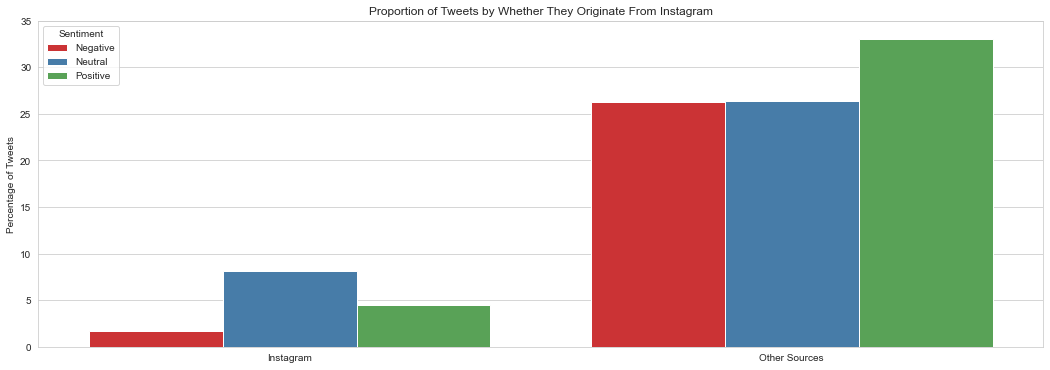

In [64]:
# create feature recording whether a tweet originated from Instagram
tweets['instagram'] = tweets['sourceLabel'].apply(lambda x: 1 * (x == 'Instagram'))

# initialize variable
first = True

# loop through sentiments
for sent in [-1, 0, 1]:
    
    # compute percentages
    temp_df = tweets[tweets['sentiment'] == sent]['instagram'].value_counts().reset_index()
    temp_df['instagram'] *= 100 / tweets.shape[0]
    
    # rename columns
    temp_df.columns = ['instagram', 'Percentage of Tweets']
    
    # add feature recording sentiment
    temp_df['Sentiment'] = sent_dict[sent]
    
    # concatenate dataframes
    if first:
        perc = temp_df
        first = False
    else:
        perc = pd.concat([perc, temp_df]).reset_index(drop = True)

# make plot
plt.figure(figsize = (18, 6))
fig = sns.barplot(data = perc, x = 'instagram', y = 'Percentage of Tweets', hue = 'Sentiment', order = [1, 0], palette = 'Set1')
fig.set(title = 'Proportion of Tweets by Whether They Originate From Instagram', xlabel = '', ylim = [0, 35],
        xticklabels = ['Instagram', 'Other Sources'])
plt.show()

It looks quite evident that the distribution in sentiment in tweets coming from Instagram is quite different from those originating in other sources. Let's apply a chi-squared test to verify the existence of this difference.

In [65]:
# restrict attention to non-neutral tweets
has_sent = tweets[tweets['sentiment'] != 0]

# create frequency table
freq = has_sent.groupby(['sentiment', 'instagram']).count()[['date']]
freq.columns = ['']
freq = freq.unstack()

# compute p-value and expected frequencies
chi = stats.chi2_contingency(freq)
pval = chi[1]
exp = pd.DataFrame(chi[3], index = [-1, 1])

# format expected frequencies table
exp.index.names = ['sentiment']
exp.columns.names = ['instagram']

# print p-value, frequency table, and expected frequency table
print('Chi-squared p-value: {:.2e}'.format(pval))
print('\n')
print('Frequency table:')
print(freq)
print('\n')
print('Expected frequency table:')
print(exp)

Chi-squared p-value: 3.19e-33


Frequency table:
                     
instagram     0     1
sentiment            
-1         5965   395
 1         7490  1029


Expected frequency table:
instagram            0           1
sentiment                         
-1         5751.313932  608.686068
 1         7703.686068  815.313932


The chi-squared test reaffirms our suspicion that the proportion of positive tweets coming from Instagram is higher than the proportion from other sources. Indeed, the number of positive tweets coming from Instagram is 26% than expected, which is a rather substantial difference.

### **tcooutlinks** and **media**

Let's turn our attention to the **tcooutlinks** and **media** features. Recall that these features record the number of hyperlinks and media links, respectively, in a given tweet. Let's first get some summary statistics.

In [66]:
# summary statistics
tweets[tweet_links].describe()

,tcooutlinks,media
count,22699.000000,22699.000000
mean,0.294022,0.308604
std,0.460421,0.663395
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,3.000000,4.000000


Not too many tweets have hyperlinks or media links.

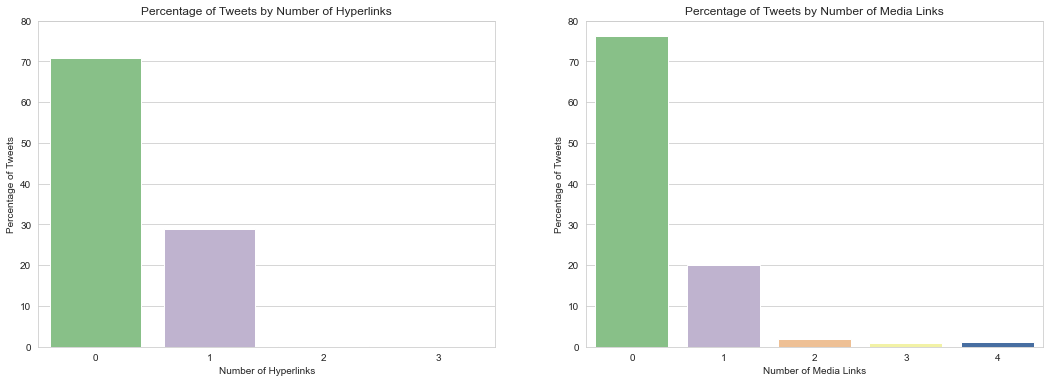

In [67]:
# graph parameters
names = {'tcooutlinks':'Hyperlinks', 'media':'Media Links'}

# intialize figure
plt.figure(figsize = (18, 6))
i = 1

# loop through features
for feat in tweet_links:
    
    # compute percentages
    perc = tweets[feat].value_counts().reset_index()
    perc[feat] *= 100 / tweets.shape[0]

    # rename columns
    perc.columns = [feat, 'Percentage of Tweets']
    
    # make plot
    plt.subplot(1, 2, i)
    fig = sns.barplot(data = perc, x = feat, y = 'Percentage of Tweets', palette = 'Accent')
    fig.set(title = 'Percentage of Tweets by Number of {}'.format(names[feat]), xlabel = 'Number of {}'.format(names[feat]),
            ylim = [0, 80])
    
    # increment counter
    i += 1
    
# display plots
plt.show()

Is there a relationship between sentiment and the number of hyperlinks/media links a tweet has?

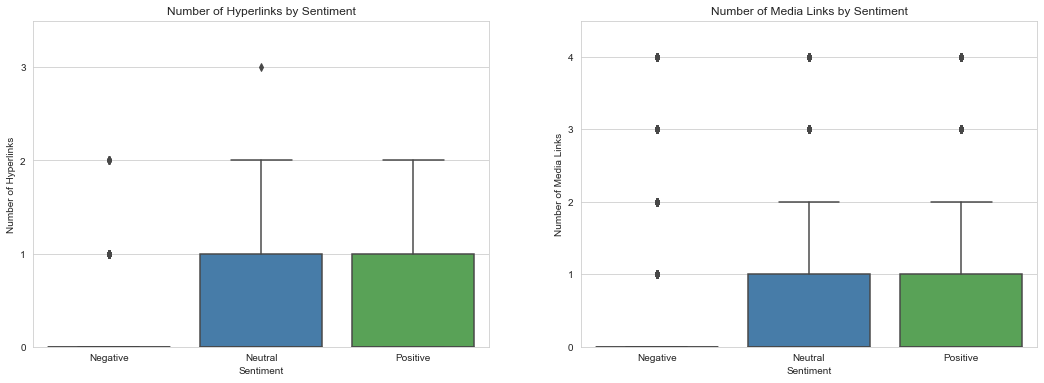

In [68]:
# graph parameters
ylims = {'tcooutlinks':[0, 3.5], 'media':[0, 4.5]}

# initialize figure
plt.figure(figsize = (18, 6))
i = 1

# loop through features
for feat in tweet_links:
    
    # make plot
    plt.subplot(1, 2, i)
    fig = sns.boxplot(data = tweets, x = 'sentiment', y = feat, palette = 'Set1')
    fig.set(title = 'Number of {} by Sentiment'.format(names[feat]), xlabel = 'Sentiment',
            ylabel = 'Number of {}'.format(names[feat]), ylim = ylims[feat], yticks = np.arange(0, ylims[feat][1] + 0.5),
            xticklabels = sentiments)
    
    # increment counter
    i += 1
    
# display plots
plt.show()

Positive tweets appear to have more hyperlinks and more media links than negative ones. Let's conduct some Welch's t-tests.

In [69]:
# loop through features
for feat in tweet_links:
    
    # get counts
    a = tweets[tweets['sentiment'] == 1][feat]
    b = tweets[tweets['sentiment'] == -1][feat]
        
    # apply Welch's t-test
    pval = stats.ttest_ind(a, b, equal_var = False).pvalue
    
    # print p-value
    print('\n')
    print("Welch's t-test p-value for number of {}: {:.2e}".format(names[feat].lower(), pval))



Welch's t-test p-value for number of hyperlinks: 5.57e-37


Welch's t-test p-value for number of media links: 5.53e-29


Hence we can conclude that positive tweets tend to have more hyperlinks and media links, averaging 0.29 hyperlinks and 0.34 media links per tweet, than negative ones, which average 0.20 hyperlinks and 0.22 media links per tweet. This is a rather substantial relative effect size.

### **mentionedUsers** and **hasMentions**

Now let's focus on the data pertaining to mentioned users. How many tweets mention users?

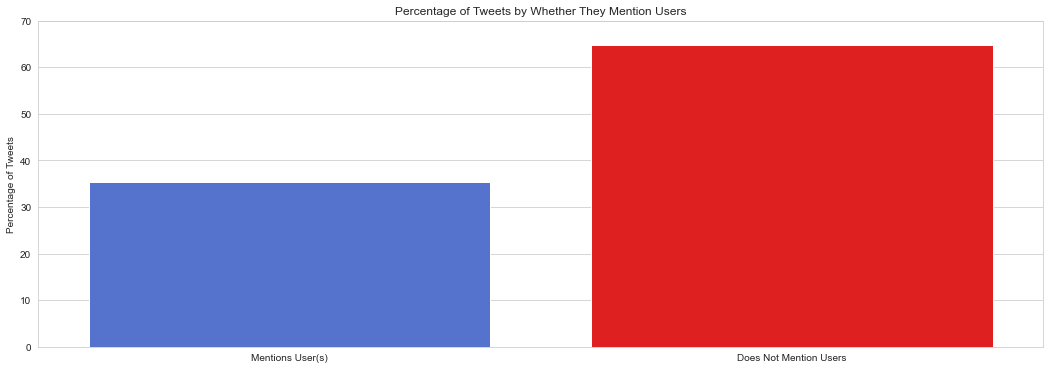

In [70]:
# compute percentages
perc = tweets['hasMentions'].value_counts().reset_index()
perc['hasMentions'] *= 100 / tweets.shape[0]

# rename columns
perc.columns = ['hasMentions', 'Percentage of Tweets']

# make plot
plt.figure(figsize = (18, 6))
fig = sns.barplot(data = perc, x = 'hasMentions', y = 'Percentage of Tweets', order = [1, 0], palette = {1:'royalblue', 0:'r'})
fig.set(title = 'Percentage of Tweets by Whether They Mention Users', xlabel = '', ylim = [0, 70],
        xticklabels = ['Mentions User(s)', 'Does Not Mention Users'])
plt.show()

Only about 35% of tweets mention another user. Is there a difference sentiment-wise between the tweets which mention users and those which do not? To answer this question we conduct a chi-squared test.

In [71]:
# create frequency table
freq = has_sent.groupby(['sentiment', 'hasMentions']).count()[['date']]
freq.columns = ['']
freq = freq.unstack()

# compute p-value and expected frequencies
chi = stats.chi2_contingency(freq)
pval = chi[1]
exp = pd.DataFrame(chi[3], index = [-1, 1])

# format expected frequencies table
exp.index.names = ['sentiment']
exp.columns.names = ['hasMentions']

# print p-value, frequency table, and expected frequency table
print('Chi-squared p-value: {:.2e}'.format(pval))
print('\n')
print('Frequency table:')
print(freq)
print('\n')
print('Expected frequency table:')
print(exp)

Chi-squared p-value: 6.83e-07


Frequency table:
                       
hasMentions     0     1
sentiment              
-1           4019  2341
 1           5040  3479


Expected frequency table:
hasMentions            0            1
sentiment                            
-1           3872.252167  2487.747833
 1           5186.747833  3332.252167


From the chi-squared test we conclude that there is a statistically significant difference in sentiment between the tweets which mention other users and the tweets which do not. However, based on the frequency table and expected frequency table we find the difference between the groups to be rather small. Indeed, there are more positive tweets which mention users than expected but the difference between the observed and expected values is less than 5%.

Now let's look at the actual mentioned users. For each mentioned user in our dataset we count the number of tweets they appear in and the average sentiment score of the tweets in which they are mentioned.

In [72]:
# initialize dictionary to store mentioned users with counts and sentiment score
mentioned_users = dict()

# loop through tweets
for tweet in tweets.index:
    
    # list of mentioned users
    mentions = tweets.loc[tweet, 'mentionedUsers']
    
    # remove duplicate mentions
    mentions = list(set(mentions))
    
    # loop through mentions
    for user in mentions:
        
        # increase count and score
        if user in mentioned_users:
            mentioned_users[user][0] += 1
            mentioned_users[user][1] += tweets.loc[tweet, 'score']
        else:
            mentioned_users[user] = [1, tweets.loc[tweet, 'score']]

# convert to dataframe
mentioned_users = pd.DataFrame(mentioned_users.items())

# create counts feature
mentioned_users['count'] = mentioned_users[1].apply(lambda x: x[0])

# get total score
mentioned_users['score'] = mentioned_users[1].apply(lambda x: x[1])

# convert total score to mean
mentioned_users['score'] = mentioned_users.apply(lambda x: x['score'] / x['count'], axis = 1)

# drop redundant column
mentioned_users.drop([1], axis = 1, inplace = True)

# rename column
mentioned_users.columns = ['user', 'count', 'score']

# summary statistics
mentioned_users.describe(percentiles = [0.25, 0.5, 0.75, 0.95])

,count,score
count,2765.000000,2765.000000
mean,5.348644,0.103174
std,49.397784,0.275373
min,1.000000,-0.924600
25%,1.000000,0.000000
50%,1.000000,0.066963
75%,2.000000,0.246300
95%,12.000000,0.611400
max,2176.000000,0.966900


Our tweets mention 2765 unique users, most of which are only mentioned once per the median count of 1. We also find that the mean sentiment score of tweets mentioning users warrants a positive sentiment. By contrast, the mean sentiment score over the entire dataset is about 0.045, yielding an overall neutral sentiment. This further reaffirms our finding that tweets mentioning users tend to be more positive.

Who are the most mentioned users?

In [73]:
# most mentioned users
mentioned_users.sort_values('count', ascending = False).head()

,user,count,score
2,TTChelps,2176,0.032370
3,TTCnotices,746,0.022608
6,JohnTory,588,0.032822
97,bradTTC,577,0.081557
17,Metrolinx,443,0.022397


The five most mentioned users appear in tweets that are, on average, either neutral or positive. On the one hand, this is not too surprising since we know that tweets which mention users tend to be more positive. On the other hand, this is a little surprising considering who these oft-mentioned users are. For example, [@TTChelps](https://twitter.com/TTChelps) is the TTC's customer service Twitter account. My initial suspicion was that the tweets which mention the TTC's customer service page would be negative. Generally speaking, I would guess that customers contact customer service primarily following negative experiences. However, the mean sentiment score of the tweets mentioning @TTChelps is essentially neutral! The same is true of [@TTCnotices](https://twitter.com/TTCnotices), which is the account which posts TTC service alerts. Rather shockingly, the Twitter account which largely tweets about service delays and disruptions is mentioned in tweets which have on average a neutral sentiment score!

The other accounts in our top five are

* [@JohnTory](https://twitter.com/JohnTory) - the account of Toronto mayor John Tory
* [@bradTTC](https://twitter.com/bradTTC) - currently inactive but formerly belonged to Brad Ross, who used to be the TTC's chief spokesman (at the time of this writing, Brad works as Toronto's chief communications officer)
* [@Metrolinx](https://twitter.com/Metrolinx) - the company that manages the TTC's PRESTO fare collection system

We can get a better sense of the distribution of users mentioned in our dataset with a word cloud.

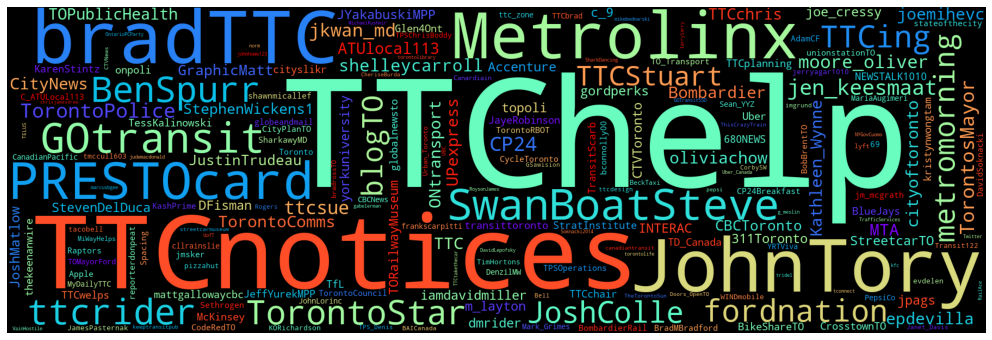

In [74]:
# initialize string of mentioned users
mentions = ''

# loop through tweets
for tweet in tweets.index:
    
    # current list of mentioned users
    curr_mentions = tweets.loc[tweet, 'mentionedUsers']
    
    # remove duplicates
    curr_mentions = list(set(curr_mentions))
    
    # convert list of mentioned users to string
    curr_mentions = ' '.join(curr_mentions)
    
    # add mentioned users to string
    mentions += curr_mentions + ' '

# make word cloud
wcloud = WordCloud(width = 1800, height = 600, random_state = 18, collocations = False, colormap = 'rainbow',
                   include_numbers = True).generate(mentions)
plt.figure(figsize = (18, 6))
plt.imshow(wcloud)
plt.axis('off')
plt.show()

Now let's take a look at the most positive and negative of the popular mentioned users. What constitutes a "popular" user can be arbitrary but we shall opt with those which are mentioned in more than 12 tweets, putting them in the top five percentile of mentions. We start with the most positive of the popular users.

In [75]:
# most positive users
mentioned_users[mentioned_users['count'] > 12].sort_values('score', ascending = False).head()

,user,count,score
1255,BlueJays,25,0.450362
607,Raptors,18,0.327393
14,jmsker,18,0.314848
1024,PepsiCo,13,0.314179
739,yorkuniversity,31,0.305697


Having [@BlueJays](https://twitter.com/BlueJays) and [@Raptors](https://twitter.com/Raptors) among the most positive mentioned users is pretty reasonable as these two accounts belong to the Toronto Blue Jays and Toronto Raptors, respectively. How about the others?

The user [@jmsker](https://twitter.com/jmsker), Crosslinx Technical Director Joanna Kervin, is third on our list of most positive mentioned users. Let's see why this might be.

In [76]:
# function to return tweets mentioning user
def tweets_mention(user):
    
    # initialize index
    ind = []
    
    # loop through tweets
    for tweet in tweets.index:
        
        # get list of mentioned users
        mentions = tweets.loc[tweet, 'mentionedUsers']
        
        # check for mentioned user
        if user in mentions:
            ind.append(tweet)
            
    # return tweets with specified user
    return tweets.loc[ind, :]

In [77]:
# tweets mentioning @jmsker
tweets_mention('jmsker')[['date', 'content', 'username', 'score']]

,date,content,username,score
39,2021-06-02,@jmsker @TorontoRailways @CrosstownTO @crosslinx One doesn't resemble the other. Why the difference? Why Subway Font on the platform and whatever this is at the entrance? #TTC,5151photography,0.000000
8120,2017-12-30,More station pictures. Toronto's newest railway station. @TORailwayMuseum #ttc #gotransit @jmsker #onpoli #TYSSE,chrisjamesdrew,0.172000
8121,2017-12-30,Checking out the new Downsview Park @GOtransit Station with @femwriter. Capacity for three tracks here. #ttc #topoli #TYSSE @jmsker @_keerthanak @Canardiain @TORailwayMuseum @EMcMahonBurl @Metrolinx @sMoneyON #onpoli #gotransit,chrisjamesdrew,0.172000
8158,2017-12-25,Hi from York U. #NoMore196 #TYSSE @jmsker @_keerthanak #ttc #topoli,chrisjamesdrew,0.171200
8298,2017-12-17,That's me in the red knapsack :) #TYSSE #Line1Ext #MyIdeaOfAWeekend @jmsker @femwriter @sMoneyON #ttc #topoli,chrisjamesdrew,0.745600
8306,2017-12-17,The view from Pioneer Village station. This station is on the #Toronto-York Region border. I was here at the end of 2016 for a tour with @jmsker and to write about the year-long countdown to today’s opening ( What a difference a year makes. #TYSSE #TTC,NWestoll,0.095450
8308,2017-12-17,Now that must have been a fun and complex concrete pour! #CoolConstruction @FernSerafim @SkyJacked793 @rail613 @Canardiain @jmsker #TYSSE #Line1ext #ttc #topoli #onpoli,chrisjamesdrew,0.620150
8310,2017-12-17,"First northbound train at 8am, meeting of @JohnTory and @Kathleen_Wynne on the Toronto-Vaughan border at platform level, and BRT-subway integration on Highway 7. #TYSSE #Line1Ext #ttc #topoli #onpoli @jmsker @TTCsue @StevenDelDuca @femwriter @sMoneyON",chrisjamesdrew,0.258000
8321,2017-12-17,On my way to #Line1Ext #TYSSE cc @jmsker #ttc #topoli #transitfan #onpoli,chrisjamesdrew,0.684100
8330,2017-12-16,Checked out the subway extension to Vaughan this AM. Will ride again on 1st train. Fun to chat w/ @jmsker who worked on project from beginning. Rode w/ @AlexanderGlista & many transit topics were covered. @TTCsue @TTChelps @bradTTC @StevenDelDuca @femwriter #ttc #topoli #onpoli,chrisjamesdrew,0.102120


Joanna Kervin appears to be related to the [TTC's line 1 extension](https://www.cbc.ca/news/canada/toronto/from-vaughan-to-union-in-42-minutes-no-traffic-no-delays-when-line-1-extension-opens-1.4377250) which opened in late 2017. Expanding TTC service is always welcome news which explains why tweets mentioning @jmsker are generally positive.

Why is [@PepsiCo](https://twitter.com/PepsiCo), the Twitter account for, well, PepsiCo, in the top five?

In [78]:
# tweets mentioning @PepsiCo
tweets_mention('PepsiCo')[['date', 'content', 'username', 'score']]

,date,content,username,score
5029,2018-11-21,"10/ A far simpler legal, financial, governance, operating solution would be to have ALL #TTC & GTA public transit agencies present their operating & capital budgets to @Metrolinx Board for approval, to ensure financial probity, foster competition & innovation—eg. @PepsiCo #TOpoli",BobBrentTO,0.408800
5057,2018-11-19,"@johnhowe123 #TTC doesn't understand marketing basics; sophisticated marketing general management of consumer-packaged goods, or, @PepsiCo's obsession with ultra-heavy users & learning from competition at its @Pepsi, @FritoLay, @KFC, @PizzaHut & @TacoBell operating divisions. So #Metropass📉",BobBrentTO,0.148000
5366,2018-10-23,"@BenSpurr @ONtransport @JYakabuskiMPP @TorontoStar @PRESTOcard @Metrolinx @fordnation @Accenture @INTERAC @TD_Canada @topoli @onpoli @McKinsey @StratInstitute @SwanBoatSteve @69 @Bombardier @TfL @kellogg @Campbells @Samsung @PepsiCo @pizzahut @tacobell @ConagraFoods 3f-xxix/ I feel for #TTC CEO Rick Leary, a good public transit operator, who was dealt a bad hand by his predecessor, who promote...",BobBrentTO,0.659700
5367,2018-10-23,"@BenSpurr @ONtransport @JYakabuskiMPP @TorontoStar @PRESTOcard @Metrolinx @fordnation @Accenture @INTERAC @TD_Canada @topoli @onpoli @McKinsey @StratInstitute @SwanBoatSteve @69 @Bombardier @TfL @kellogg @Campbells @Samsung @PepsiCo @pizzahut @tacobell @ConagraFoods 3f-xxviii/ After my interventions fell on deaf ears, of the importance of marketing(—to heavy-user Metropass users to sustain #TT...",BobBrentTO,0.361200
5368,2018-10-23,"@BenSpurr @ONtransport @JYakabuskiMPP @TorontoStar @PRESTOcard @Metrolinx @fordnation @Accenture @INTERAC @TD_Canada @topoli @onpoli @McKinsey @StratInstitute @SwanBoatSteve @69 @Bombardier @TfL 3f-xxvii/ In financially disciplined packaged goods companies Mark (@Kellogg's, @Campbells, @Samsung) & I (#GF, #RalstonPurina, @PepsiCo: #PFSI—@PizzaHut/@TacoBell, @ConAgraFoods) worked for, marketing...",BobBrentTO,0.000000
5409,2018-10-21,"@BenSpurr @ONtransport @JYakabuskiMPP @TorontoStar @PRESTOcard @Metrolinx @fordnation @Accenture @INTERAC @TD_Canada @topoli @onpoli @PepsiCo @pepsi @Fritolay @kfc @pizzahut @tacobell @TorontoCouncil @TorontosMayor @JohnTory @Bombardier @globeandmail 3t/ #SheppardStubway, @UPexpress, #TYSSE, #SSE 1-🛑, #SMARTtrack, #DTRL are all reasons why @Metrolinx must assume be ""adult"" to enforce financia...",BobBrentTO,0.776100
5410,2018-10-21,"@BenSpurr @ONtransport @JYakabuskiMPP @TorontoStar @PRESTOcard @Metrolinx @fordnation @Accenture @INTERAC @TD_Canada @topoli @onpoli @PepsiCo @pepsi @Fritolay @kfc @pizzahut @tacobell @TorontoCouncil @TorontosMayor @JohnTory @Bombardier 3q/ @TorontosMayor @JohnTory interferred, inappropriatedly, in #TTC Commission governance by embargoing release of #SSE's 30% Design CAPEX est. until 2019, to ...",BobBrentTO,0.007433
5411,2018-10-21,@BenSpurr @ONtransport @JYakabuskiMPP @TorontoStar @PRESTOcard @Metrolinx @fordnation @Accenture @INTERAC @TD_Canada @topoli @onpoli @PepsiCo @pepsi @Fritolay @kfc @pizzahut @tacobell @TorontoCouncil @TorontosMayor @JohnTory @Bombardier 3p/ Despite the fact #SMARTtrack is widely panned as a figment of Mayor @JohnTory's 2014 Mayoral election campaign…he persists in 2018 election in insisting 6 ...,BobBrentTO,-0.400850
5412,2018-10-21,"@BenSpurr @ONtransport @JYakabuskiMPP @TorontoStar @PRESTOcard @Metrolinx @fordnation @Accenture @INTERAC @TD_Canada @topoli @onpoli @PepsiCo @pepsi @Fritolay @kfc @pizzahut @tacobell 3k/ The most disciplined & sophisticated of the American multi-national companies I worked for: in operations, best business, competition, finance, marketing practises, absent at @Metrolinx & #TTC. In 1997, @Peps...",BobBrentTO,0.843400
5417,2018-10-20,"@maryfragedakis Mary, the #TTC's ""Crown Jewels"" are its flat fare & free (now 2-hr) transfers between modes. A much simpler solution than 🚇upload wld be for @Metrolinx to adopt @PepsiCo Governance model (it was corporate bank) approving 

Every tweet mentioning @PepsiCo is from [@BobBrentTO](https://twitter.com/BobBrentTO). Bob seems to be relating some TTC business practices with that of PepsiCo and as we can see many of Bob's tweets mention a rather large number of users. Thus while @PepsiCo indeed appears among the most positive tweets, its inclusion in these tweets is somewhat peripheral.

Rounding out our list of the most positive popular mentions is [@yorkuniversity](https://twitter.com/yorkuniversity), the aptly named Twitter account of York University. Let's have a look at the tweets mentioning them.

In [79]:
# tweets mentioning @yorkuniversity
tweets_mention('yorkuniversity')[['date', 'content', 'username', 'score']]

,date,content,username,score
3498,2019-04-11,About to make my first journey to @yorkuniversity on the subway 🚉 for the #MIRCI conference 🤓 Wish me luck! #TTC #ttcdontmakemelate #alreadystoppedafteronestopahh,latarasoff,0.120500
5652,2018-09-28,"@JasonParis @frankscarpitti @yorkuniversity @TorontosMayor @JohnTory @30 10/ Many millennials & Gen Z #TTC riders don't know that prior to Megacity Mayors Ford & Tory, a Mayoral transit plan wasn't a prerequisite to getting elected. Mayors Miller & Lastman were both elected 2X w/o unvetted, unfunded transit plans NB #BADtransitMayor @JohnTory #TOpoli",BobBrentTO,-0.320400
5653,2018-09-28,"@JasonParis @frankscarpitti @yorkuniversity @TorontosMayor @JohnTory 9/ How can #TTC approve $8B (0% design) DTRL, w/o first determining its #rides, pass.rev, OpExp, Op$ubs, CAPEX, funding? Well, it's deja vu: original Spadina🚇extension, Sheppard🚇, #TYSSE🚇1.2M rides/yr, $3.2B, #SSE🚇 likely $5B @30% design, #SMARTtrack🚅 6M new rides/$1.7B💲🆘",BobBrentTO,0.439850
6463,2018-06-17,Just getting ready to head off on the #BikeNorthYork @BikeMonth ride. This year we're starting at the @yorkuniversity #TTC stop and riding to Downsview Park. #bikeTO #BikeMonth @CycleToronto #BuildTheGrid,cjhoyle_com,0.021733
7517,2018-02-21,Taking the #TTC up to campus today. I’ll be the giddy one checking out the new stops en route to @yorkuniversity,mobilizemichael,-0.148000
8028,2018-01-09,Today we decided to check out the new transit options that some of our postsecondary friends will be taking! How has your experience with the #ttc extension been? @yorkuniversity,TrinityToronto,0.175167
8228,2017-12-18,"The opening of the @TTCnotices subway extension is a huge deal to me, and to many Torontonians. I remember when they started building this station way back when I was still a @yorkuniversity student. 🚇 #TTC #Toronto",VWCpodcast,0.106067
8313,2017-12-17,The view from @yorkuniversity subway station. Quite a few people here right now. This will probably be the busiest station on the #TYSSE come tomorrow morning. #TTC,NWestoll,0.129000
8347,2017-12-15,Great time lapse of @yorkuniversity station construction #Line1Ext #TYSSE #TTC @bradTTC @TTChelps @TTCStuart @EllisDon,jmsker,0.814300
8432,2017-12-12,#TTC Countdown: 5 days to go to opening of #Line1Ext #TYSSE #PioneerVillage station @Yorkuniversity #Vaughan @bradTTC @TTChelps @TTCStuart,jmsker,0.516000


A significant portion of tweets mentioning @yorkuniversity pertain to the Line 1 extension, which, among other things, extended subway service right to York University. We already noted that the opening of this extension led to many positive tweets so it makes sense for @yorkuniversity to make an appearance in the top five.

Now to the opposite end of the spectrum. Which of the popular mentioned users appear in the most negative tweets?

In [80]:
# most negative users
mentioned_users[mentioned_users['count'] > 12].sort_values('score').head()

,user,count,score
171,globalnewsto,22,-0.181381
194,TorontosMayor,82,-0.093339
1515,CP24Breakfast,18,-0.084374
672,CityPlanTO,18,-0.081830
109,CP24,88,-0.067559


The most negative of the popular mentioned users naturally splits into two groups. In one group we have [@globalnewsto](https://twitter.com/globalnewsto), [@CP24Breakfast](https://twitter.com/CP24Breakfast), and [@CP24](https://twitter.com/CP24), which are the Twitter accounts of Global News Toronto, CP24 Breakfast, and CP24, respectively. These are all news networks/news programs and truth be told, news stories are quite often negative so in hindsight it is unsurprising to find these three accounts here.

The second group consists of [@TorontosMayor](https://twitter.com/TorontosMayor), the account of Toronto mayor John Tory, and [@CityPlanTO](https://twitter.com/CityPlanTO), the account of Toronto's City Planning Division. Both accounts are tied to Toronto politics and it makes sense that both have negative sentiment scores. Indeed, displeased Torontonians would only naturally voice their concerns to the politicians and/or organizations that can properly address them.

What is interesting to note is that Toronto Mayor John Tory has two Twitter accounts: the Twitter verified @JohnTory as well as @TorontosMayor. We saw that @TorontosMayor is the is the second most negative mentioned user so it is only natural to see how @JohnTory compares.

In [81]:
# compare @JohnTory and @TorontosMayor
mentioned_users[mentioned_users['user'].isin(['JohnTory', 'TorontosMayor'])]

,user,count,score
6,JohnTory,588,0.032822
194,TorontosMayor,82,-0.093339


This difference in sentiment score is quite interesting as it puts @JohnTory in neutral territory while @TorontosMayor is negative. We should first verify that this difference is in fact statistically significant.

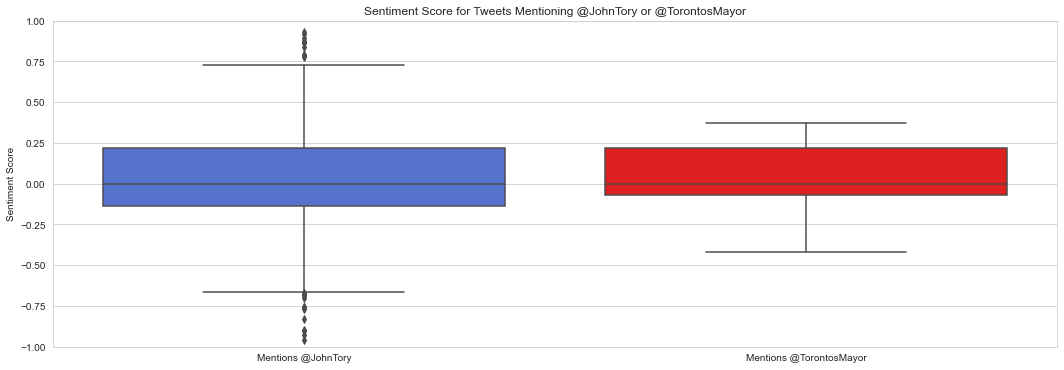

In [82]:
# tweets mentioning either @JohnTory or @TorontosMayor
mention_mayor = pd.concat([tweets_mention('JohnTory'), tweets_mention('TorontosMayor')])

# remove duplicate tweets
mention_mayor = mention_mayor[~mention_mayor.index.duplicated()]

# feature to record whether mentions @JohnTory
mention_mayor['johnTory'] = mention_mayor['mentionedUsers'].apply(lambda x: 1 * ('JohnTory' in x))

# make plot
plt.figure(figsize = (18, 6))
fig = sns.boxplot(data = mention_mayor, x = 'johnTory', y = 'score', order = [1, 0], palette = {0:'r', 1:'royalblue'})
fig.set(title = 'Sentiment Score for Tweets Mentioning @JohnTory or @TorontosMayor', xlabel = '', ylabel = 'Sentiment Score',
        ylim = [-1, 1], xticklabels = ['Mentions @JohnTory', 'Mentions @TorontosMayor'])
plt.show()

From the box plot alone there does appear to be much difference between the two. We apply a Welch's t-test to ascertain whether there really exists a difference.

In [83]:
# get sentiment
a = tweets_mention('JohnTory')['score']
b = tweets_mention('TorontosMayor')['score']

# apply Welch's t-test
pval = stats.ttest_ind(a, b, equal_var = False).pvalue

# print p-value
print("Welch's t-test p-value: {:.2e}".format(pval))

Welch's t-test p-value: 3.36e-03


Although unclear from the box plot alone, we find that there really is a statistically significant difference in mean sentiment score between the tweets which mention @JohnTory and those which mention @TorontosMayor.

One possible explanation is that @TorontosMayor belongs to whoever the mayor happens to be at the time and so maybe @TorontosMayor refers to John Tory and possibly other past mayors. John Tory has been the mayor of Toronto since December 1, 2014 and at the time of this writing he still serves as mayor of Toronto. Are any of the tweets in our dataset from before his time as mayor?

In [84]:
# earliest mention of @TorontosMayor
early_mayor = tweets_mention('TorontosMayor')['date'].min()

# print earliest mention
print("Earliest mention of @TorontosMayor is {}".format(early_mayor.strftime('%B %#d, %Y')))

Earliest mention of @TorontosMayor is May 4, 2018


That disproves that hypothesis. It is unclear to me why there would be a statistically significant difference in sentiment but nonetheless there is a difference.

### Exploring the Hashtag Data

In a manner similar to the **mentionedUsers** feature, we have a list of hashtags appearing in each tweet stored in the **hashtags** feature. We investigate this feature just as we did the **mentionedUsers** feature, determining which hashtags are most frequently employed as well as the most positive and negative hashtags.

As before, let's create a dataframe recording the number of times each hashtag is used as well as the mean sentiment score of the tweets containing said hashtag. We omit the #ttc hashtag from our analysis since this hashtag appears in every tweet by construction.

In [85]:
# initialize dictionary to store hashtags with counts and sentiment score
hashtags = dict()

# loop through tweets
for tweet in tweets.index:
    
    # list of hashtags
    tags = tweets.loc[tweet, 'hashtags']
    
    # remove duplicate hashtags
    tags = list(set(tags))
    
    # loop through hashtags
    for tag in tags:
        
        # increase count and score
        if tag in hashtags:
            hashtags[tag][0] += 1
            hashtags[tag][1] += tweets.loc[tweet, 'score']
        else:
            hashtags[tag] = [1, tweets.loc[tweet, 'score']]

# remove #ttc since it appears in every tweet
del hashtags['ttc']

# convert to dataframe
hashtags = pd.DataFrame(hashtags.items())

# create counts feature
hashtags['count'] = hashtags[1].apply(lambda x: x[0])

# get total score
hashtags['score'] = hashtags[1].apply(lambda x: x[1])

# convert total score to mean
hashtags['score'] = hashtags.apply(lambda x: x['score'] / x['count'], axis = 1)

# drop redundant column
hashtags.drop([1], axis = 1, inplace = True)

# rename column
hashtags.columns = ['hashtag', 'count', 'score']

# summary statistics
hashtags.describe(percentiles = [0.25, 0.5, 0.75, 0.95])

,count,score
count,10136.000000,10136.000000
mean,3.888220,0.094028
std,53.384114,0.321827
min,1.000000,-0.970500
25%,1.000000,-0.032025
50%,1.000000,0.025800
75%,2.000000,0.274950
95%,9.000000,0.685588
max,4595.000000,0.966900


There are just over ten thousand unique hashtags in our dataset. As was the case with mentioned users, most hashtags appear only once in the entire dataset.

Which hashtags are the most common?

In [86]:
# most common hashtags
hashtags.sort_values('count', ascending = False).head(10)

,hashtag,count,score
8,toronto,4595,0.068032
20,topoli,2222,0.052210
305,transit,875,0.070236
157,subway,826,0.064793
6,streetcar,526,0.077880
154,onpoli,417,0.027301
44,ontario,349,0.077879
71,canada,308,0.096392
752,yyz,251,0.075717
264,presto,209,-0.036291


The top ten most used hashtags are all quite sensible and have sentiment scores that correspond to either neutral or positive sentiment. Most of the hashtags are quite clear in what they represent but others are not so obvious.

* #topoli - typically stylized as #TOpoli, this hashtag is used to discuss Toronto politics
* #onpoli - more commonly #ONpoli, this hashtag is for Ontario politics
* #yyz - the identification code of Toronto's Pearson International Airport
* #presto - the fare collection system used by the TTC

All in all there is nothing shocking about the most common hashtags. Let's visualize the frequency of hashtags in our dataset with a word cloud, again omitting the #TTC hashtag.

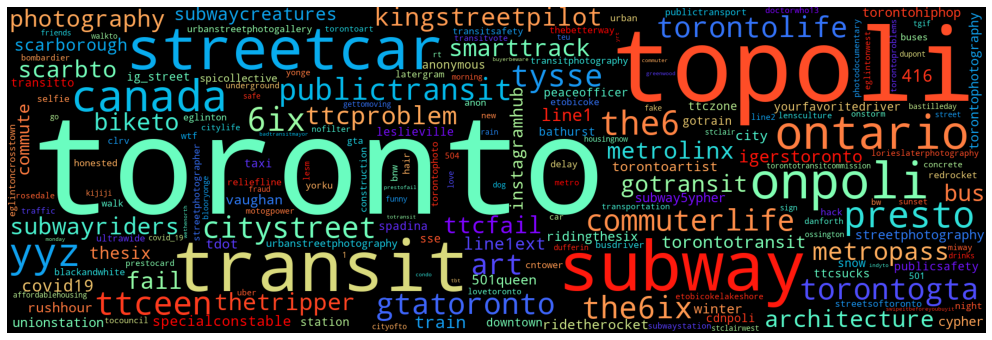

In [87]:
# initialize string of hashtags
all_hashtags = ''

# loop through tweets
for tweet in tweets.index:
    
    # current list of hashtags
    curr_hashtags = tweets.loc[tweet, 'hashtags']
    
    # remove duplicates
    curr_hashtags = list(set(curr_hashtags))
    
    # remove #ttc
    del curr_hashtags[curr_hashtags.index('ttc')]
    
    # convert list of hashtags to string
    curr_hashtags = ' '.join(curr_hashtags)
    
    # add hashtags to string
    all_hashtags += curr_hashtags + ' '

# make word cloud
wcloud = WordCloud(width = 1800, height = 600, random_state = 18, collocations = False, colormap = 'rainbow',
                   include_numbers = True).generate(all_hashtags)
plt.figure(figsize = (18, 6))
plt.imshow(wcloud)
plt.axis('off')
plt.show()

Recall that #subway and #streetcar were the fourth and fifth, respectively, most commonly used hashtags and thus are represented rather prominently in the word cloud. It is interesting to note that the hashtags representing the third transit type, namely #bus and #buses, are much less notable in the word cloud.

Now let's try to determine which of our most popular hashtags are among the most positive. We use the same threshold in deciding what constitutes a "popular" hashtag as in the case of mentioned users, namely a popular hashtag is one in the top five percentile of usage. This amounts to only considering hashtags that appear in at least 10 distinct tweets.

In [88]:
# most positive hashtags
hashtags[hashtags['count'] >= 10].sort_values('score', ascending = False).head()

,hashtag,count,score
5660,phoneafriend,23,0.776737
6927,honestedstation,17,0.765753
6008,friends,28,0.742412
4459,lovecanada,16,0.713847
2658,drinks,25,0.703990


The #friends, #lovecanada, and #drinks hashtags are quite sensibly among the most positive hashtags. Why are #phoneafriend and #honestedstation so positive?

In [89]:
# function to return tweets with hashtag
def tweets_hashtag(hashtag):
    
    # initialize index
    ind = []
    
    # loop through tweets
    for tweet in tweets.index:
        
        # list of hashtags
        tags = tweets.loc[tweet, 'hashtags']
        
        # check for hashtag
        if hashtag in tags:
            ind.append(tweet)
            
    # return tweets with specified user
    return tweets.loc[ind, :]

In [90]:
# tweets with the #phoneafriend hashtag
tweets_hashtag('phoneafriend')[['date', 'content', 'username', 'score']]

,date,content,username,score
8349,2017-12-15,"Your @TPS13Div officers and #auxiliaries are out tonight doing Holiday #RIDE in #13div! If you drink, don’t drive: find a SAFE way home #ttc #taxi #walk #phoneafriend",TPSAux13Div,0.86020
9317,2017-09-19,Watching the @BlueJays vs @royals tonight with #Friends + #Drinks? Make sure that you plan a #SAFE way home: #ttc #taxi #PhoneAFriend #Walk,TPSAux13Div,0.90490
9518,2017-08-26,Watching #MayweathervMcgregor at a bar w/friends + drinks? Please remember 2 find a SAFE way home #ttc #taxi #Walk #PhoneAFriend #FightNight,TPSAux13Div,0.38015
9579,2017-08-16,"Watching the @BlueJays at a bar / @RogersCentre, with #friends and #drinks? Remember to find a SAFE way home: #ttc #taxi #Walk #PhoneAFriend",TPSAux13Div,0.87300
9705,2017-07-28,"Watching the @BlueJays at a #bar / @RogersCentre, with #friends + #drinks? Remember to find a #SAFE way home: #TTC #Taxi #Walk #PhoneAFriend",TPSAux13Div,0.87300
10312,2017-05-17,Watching the @BlueJays vs @Braves at a bar tonight w/#friends + #drinks? Make sure you find a #SAFE way home: #ttc #taxi #walk #PhoneAFriend,TPSAux13Div,0.84550
10508,2017-04-27,Watching @Raptors vs @Bucks at a bar w/#friends + #drinks? Make sure you plan a #SAFE way home: #ttc #taxi #walk #PhoneAFriend #RaptorsGame6,TPSAux13Div,0.84550
10556,2017-04-21,Watching @MapleLeafs vs. @Capitals at a bar with #friends + #drinks? Plan a #SAFE way to get home: #TTC #Taxi #Walk #PhoneAFriend #GoLeafsGo,TPSAux13Div,0.87300
10603,2017-04-18,"Watching @Raptors at a bar, or @AirCanadaCentre, with #friends + #drinks? Remember to plan a #SAFE way home: #walk #TTC #taxi #PhoneAFriend",TPSAux13Div,0.87300
10608,2017-04-17,"Watching @MapleLeafs at a bar / @AirCanadaCentre, with #friends + #drinks? Plan a #SAFE way home: #walk #ttc #taxi #PhoneAFriend #GoLeafsGo",TPSAux13Div,0.87300


Every single tweet with the #phoneafriend hashtag is from [@TPSAux13Div](https://twitter.com/tpsaux13div), the Twitter account of the Toronto Police Service 13 Division. All the tweets are about making sure one has a safe way to get home after going out for drinks and are not about the TTC per se. How about the hashtag #honestedstation?

In [91]:
# tweets with the #honestedstation hashtag
tweets_hashtag('honestedstation')[['date', 'content', 'username', 'score']]

,date,content,username,score
12258,2016-11-16,"Signs, 1 #toronto #ttc #bathurst #honestedstation #honesteds #signs @ Bathurst (TTC)",randyfmcdonald,0.7650
12260,2016-11-16,Signs by the front door #toronto #ttc #bathurst #honestedstation #honesteds #signs @ Bathurst (TTC),randyfmcdonald,0.7650
12261,2016-11-16,Bikes and slogans #toronto #ttc #bathurst #honestedstation #honesteds #signs @ Bathurst (TTC),randyfmcdonald,0.7650
12262,2016-11-16,Fare prices #toronto #ttc #bathurst #honestedstation #honesteds #signs @ Bathurst (TTC),randyfmcdonald,0.7650
12263,2016-11-16,"Waiting, 2 #toronto #ttc #bathurst #honestedstation #honesteds #signs @ Bathurst (TTC)",randyfmcdonald,0.7650
12264,2016-11-16,Waiting #toronto #ttc #bathurst #honestedstation #honesteds #signs @ Bathurst (TTC),randyfmcdonald,0.7650
12265,2016-11-16,Westbound #toronto #ttc #bathurst #honestedstation #honesteds #signs @ Bathurst (TTC),randyfmcdonald,0.7650
12266,2016-11-16,Close-up #toronto #ttc #bathurst #honestedstation #honesteds #signs @ Bathurst (TTC),randyfmcdonald,0.7650
12267,2016-11-16,To street level #toronto #ttc #bathurst #honestedstation #honesteds #signs @ Bathurst (TTC),randyfmcdonald,0.7650
12268,2016-11-16,Going down #toronto #ttc #bathurst #honestedstation #honesteds #signs @ Bathurst (TTC),randyfmcdonald,0.7650


Tweets with the #honestedstation all originate from November of 2016. On November 1, 2016, the TTC [redecorated Bathurst station](https://www.ttc.ca/News/2016/November/11-01-2016NR.jsp) in the style of the now-closed Toronto landmark store Honest Ed's. While Honest Ed's was certainly beloved by many Torontonians, the above tweets are not especially positive. In fact, it looks like VADER is assigning rather positive scores based on the appearance of "honest" in Honest Ed's. Indeed, the tweets with the #honestedstation hashtag tend to also have the #honesteds hashtag and so the double appearance of "honest" may explain why these tweets have such positive sentiment scores.

In [92]:
# sentiment score for #honestedstation
hon_stat = sid.polarity_scores(' '.join(wordninja.split('honestedstation')))['compound']

# sentiment score for #honesteds
hon = sid.polarity_scores(' '.join(wordninja.split('honesteds')))['compound']

# print sentiment scores
print('Sentiment score of #honestedstation: {}'.format(hon_stat))
print('Sentiment score of #honesteds: {}'.format(hon))

Sentiment score of #honestedstation: 0.5106
Sentiment score of #honesteds: 0.5106


VADER is indeed assigning a rather high sentiment score to the hashtags #honestedstation and #honesteds.

What common hashtags are associated with the most negative tweets? We again only consider hashtags that appear in at least 10 tweets.

In [93]:
# most negative hashtags
most_neg_tags = hashtags[hashtags['count'] >= 10].sort_values('score').head()
most_neg_tags

,hashtag,count,score
2547,crimeprevention,13,-0.497555
2540,fraud,25,-0.411065
3919,swipeitbeforeyoubuyit,25,-0.402878
3918,craigslist,22,-0.402438
3921,alert,21,-0.395773


It turns out that most of the tweets using these hashtags originate from a single user.

In [94]:
# list of most negative hashtags
neg_tags = most_neg_tags['hashtag'].values

# loop through hashtags
first = True
for hashtag in neg_tags:
    
    # extract tweets with given hashtag
    temp_df = tweets_hashtag(hashtag)
    
    # concatenate into one dataframe
    if first:
        tweets_neg_tag = temp_df
        first = False
    else:
        tweets_neg_tag = pd.concat([tweets_neg_tag, temp_df])

# remove duplicate tweets
tweets_neg_tag = tweets_neg_tag[~tweets_neg_tag.index.duplicated()]

# sort by date
tweets_neg_tag.sort_values('date', ascending = False, inplace = True)

# display tweets
tweets_neg_tag[['date', 'content', 'username', 'score']]

,date,content,username,score
3197,2019-05-23,"Sounds too good to be true? You're right! ⚠️#ScamAlert⚠️ This is #Fraud-no such thing as an unlimited #Presto card for the #TTC. 1. You'd be giving your hard earned $ to a #Fraudster 2. If you're caught using it, you'd be given a fine. Simply not worth it! #FAREisFAIR",Transit30165,-0.003157
3204,2019-05-22,"Found on #Kijiji: #Fake #Presto card for #TTC, #YRT, #GOTransit/#Metrolinx valid for years on a one-time payment It's #NotLegit! 🚫 It's a #Scam! Don't give your 💰 to crooks! #ScamAlert #CrimePrevention #WednesdayWisdom #RiderAlert #Toronto #CityCommute #CityofTO",Transit30165,-0.101950
3643,2019-03-27,"The sign might be a little worn, but the message remains the same and always true. Parking at a #TTC #Commuter Parking Lot? 🔸️Remove #valuables from the #vehicle 🔸️Lock ALL doors #LockItOrLoseIt 🚘 #CrimePrevention",Transit30165,0.008333
3786,2019-03-07,The #TTC does not offer a electronic fare [#Presto] card for unlimited access to #transit for any # of years. This is #Fraud! Don't get caught by a #scammer...they're just taking your hard earned 💲money💲 #ScamAlert #FraudPrevention #FPM2019 #Toronto #CityofTO #ThursdayThoughts,Transit30165,-0.467450
5254,2018-11-04,"Looks legit to me!! 🤣Hahaha #FAKE METROPASS #ALERT: #TTC #November 2018 Adult #Metropass: #125935 Do not purchase, do not use! #BuyerBeware #SwipeItBeforeYouBuyIt #Kijiji #Craigslist #LetGo #Toronto #Transit #Fraud #Scam #CrimePrevention",Transit30165,-0.398100
5260,2018-11-03,"Found another one! #FAKE METROPASS #ALERT: #TTC #November 2018 Adult #Metropass: #600987 Do not purchase, do not use! #BuyerBeware #SwipeItBeforeYouBuyIt #Kijiji #Craigslist #LetGo #Toronto #Transit #Fraud #Scam #CrimePrevention",Transit30165,-0.398100
5266,2018-11-02,"#FAKE METROPASS #ALERT: #TTC #November 2018 Adult #Metropass: #008543 Do not purchase, do not use! #BuyerBeware #SwipeItBeforeYouBuyIt #Kijiji #Craigslist #LetGo #Toronto #Transit #Fraud #Scam #CrimePrevention Like & #retweet plz",Transit30165,-0.571150
5298,2018-10-30,"#FAKE METROPASS #ALERT: #TTC #November 2018 Adult #Metropass: #125935 #BuyerBeware #SwipeItBeforeYouBuyIt #Kijiji #Craigslist #LetGo #Toronto #Transit #Fraud #Scam #CrimePrevention Don't be a victim Only buy from an authorized vendor, Or use a #Presto card Like & #share plz",Transit30165,-0.795600
5332,2018-10-25,"#FAKE METROPASS #ALERT: #TTC #November 2018 Adult #Metropass: #125935 Do not purchase, do not use! #BuyerBeware #SwipeItBeforeYouBuyIt #Kijiji #Craigslist #LetGo #Toronto #Transit",Transit30165,-0.147100
5614,2018-10-03,"#FAKE METROPASS #ALERT: #TTC OCTOBER 2018 Adult #Metropass: #001717 , #021710 , #302899 Do not purchase, do not use! #BuyerBeware #SwipeItBeforeYouBuyIt #Craigslist #LetGo #Kijiji #Toronto #Transit Always buy from an authorized TTC vendor.",Transit30165,-0.147100


Most of the tweets with the most popular negative hashtags are from [@Transit30165](https://twitter.com/transit30165), a TTC special constable. This user employs several hashtags in their tweets, such as #CrimePrevention, #Fraud, #Craiglist, etc., to help prevent crime by spreading awareness of common TTC-related scams. As these tweets pertain to crime it makes sense that VADER assigns them such negative sentiment scores.

### **latitude** and **longitude**

We have features recording the latitude and longitude of the location from which a tweet originated. From this we can overlay a heatmap of tweets over a map of Toronto.

In [95]:
# set weight for folium library
tweets['weight'] = 1

# organize data for the heatmap
tweets_coords = tweets[['latitude', 'longitude', 'weight']].groupby(['latitude', 'longitude']).sum().reset_index()

# apply log transformation to standardize data
tweets_coords['weight'] = tweets_coords['weight'].apply(np.log)

# rescale weights to be proportions from 0 to 1
tweets_coords['weight'] /= tweets_coords['weight'].max()

# heatmap centre
centre_coords = (43.7068, -79.3983)

# create heatmap
tweets_map = folium.Map(location = centre_coords, control_scale = True, zoom_start = 11)
HeatMap(tweets_coords.values, min_opacity = 0.3, radius = 8, blur = 5).add_to(tweets_map)

# dictionary of notable locations
locs = {'<b>Union Station</b>':(43.6453, -79.3806),
        '<b>Bloor-Yonge Station</b>':(43.6706, -79.3865),
        '<b>Finch Station</b>':(43.7814, -79.4150),
        '<b>Kipling Station</b>':(43.6376, -79.5355),
        '<b>Vaughan Metropolitan Centre Station</b>':(43.7942, -79.5275),
        '<b>McCowan Station</b>':(43.7749, -79.2520),
        '<b>Ellesmere Station</b>':(43.767, -79.2775),
        '<b>Warden Station</b>':(43.711, -79.28),
        '<b>Dufferin Station</b>':(43.6602, -79.4357),
        '<b>Davisville Station</b>':(43.6978, -79.3966),
        '<b>Yorkdale Station</b>':(43.7246, -79.4473),
        '<b>Finch West Station</b>':(43.7631, -79.4909),
        '<b>Most common coordinates</b>':(43.403221, -79.639319)}

# add notable locations to the map
for key in locs.keys():
    folium.Marker(location = locs[key], tooltip = key).add_to(tweets_map)

# display map
tweets_map

The tweets are coming from all throughout the GTA but most originate in Toronto. If we zoom in we can notice that many subway stations, such as Bloor-Yonge, Dufferin, and Union Stations, have a rather high concentration of tweets.

Curiously, a number of tweets seem to be coming from Lake Ontario. While it's entirely possible that people are tweeting from boats, that is unlikely to be the case. The most common coordinates, which astoundingly account for over 60% of the dataset, are (43.403221$^\circ$ N, 79.639319$^\circ$ W). This is in Lake Ontario, just southeast of Oakville. Perhaps Twitter infers these coordinates when they are only able to ascertain the tweet came from the general Toronto area.

## Conclusion

This concludes the first part of this project in which we analyze the Twitter data on its own. We learned quite a bit so far. We discovered that the Covid-19 pandemic affect Twitter usage as the daily number of tweets with the #TTC hashtag drastically dropped during the pandemic.

We also discovered a difference in Twitter activity between weekdays and weekends. On average, weekdays have more daily tweets than weekends. Twitter usage also peaks twice a day on weekdays, one peak occurring at around 8 am and the other at about 5 pm. By contrast, weekend Twitter usage has no clear peak time.

I personally had some revelations when it came to exploring the sentiment data. I came into this project fully expecting tweets featuring the #TTC hashtag to be overwhelmingly negative with Torontonians expression their frustration at our transit system. To my surprise, the tweets are roughly evenly split between positive, neutral, and negative sentiments and in fact positive tweets are the most common with negative tweets the least! What is perhaps most interesting is that daily mean sentiment score does not seem all that affected by TTC-related events. While we saw huge spikes in the number of tweets on days with significant subway disruptions or on the day the Line 1 extension opened, we found no such spikes in the sentiment data. In fact, we found no relationship between daily mean sentiment score and, well, anything. In Part 2 of this project we will investigate whether there is a link between subway closures and Twitter sentiment. Before beginning this project I was certain there would be a link but now I am not so sure.

While we had little luck in finding relationships involving mean daily sentiment score, we discovered many pertaining to whether a tweet was positive, neutral, or negative. Tweets with sentiment, be it positive or negative, received slightly more replies on average than neutral tweets. We also noted that positive tweets were retweeted more often than negative tweets, in addition to garnering more likes than negative tweets. Tweets coming from Instagram tended to be more positive than tweets from other sources and tweets with links of some form, either hyperlinks or media links, were also apt to be more positive. Tweets mentioning other users also were slightly more positive than tweets without mentions, although the difference was minor.

Speaking of mentioning users, it looks like Toronto feels quite positively towards the @BlueJays and @Raptors. The Twitter accounts of these two teams were the two most positive of the commonly mentioned users. At the opposite end of the spectrum we noted that news accounts were among the most negative of the commonly mentioned users with @globalnewto, @CP24Breakfast, and @CP24 in the bottom five. Quite interestingly we also found a statistically significant difference in sentiment in tweets mentioning @JohnTory versus tweets mentioning @TorontosMayor despite both tweets corresponding to Toronto Mayor John Tory.

To finish things off we also noted from a heatmap of the tweets that many tweets were concentrated around subway stations.

In Part 2 of this project we introduce the subway closure delay data. We will peruse this dataset and try to discover some notable trends but ultimately we will try to determine whether there is a link between Twitter sentiment and subway closures. On to Part 2!